In [1]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import wandb
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_evaluation import ModelEvaluator
from scripts.medical_scripts.medical_training import Training
from scripts.MIL_utils import MIL_collate_fn

from types import SimpleNamespace
from box import Box

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import itertools
import torch
import pandas as pd
import wandb
from box import Box
from tqdm import tqdm
import os

# Modificación de run_experiment para devolver métricas
def run_experiment(config):
    # Crear un objeto temporal para compatibilidad
    class TempConfig:
        def __init__(self, config_dict):
            self.__dict__.update(config_dict)

    config_obj = TempConfig(config)

    # Iniciar wandb
    wandb.init(
        project="TFG",
        config=config
    )

    # Parámetros de configuración
    dataset_name = config_obj.dataset_name
    num_epochs = config_obj.num_epochs
    learning_rate = config_obj.learning_rate
    batch_size = config_obj.batch_size
    pooling_type = config_obj.pooling_type       
    input_feature_dim = config_obj.input_feature_dim
    feature_dim = config_obj.feature_dim

    # Directorio para guardar modelos
    output_model_dir = f"./models/{dataset_name.split('-')[0]}/{pooling_type}"
    os.makedirs(output_model_dir, exist_ok=True)

    # Cargar datasets
    train_dataset, val_dataset = load_dataset(config=config, mode="train_val")
    test_dataset = load_dataset(config=config, mode="test")

    # Crear dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=MIL_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)

    # Entrenamiento
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type=pooling_type,
        input_feature_dim=input_feature_dim,
        feature_dim=feature_dim,
        wandb=wandb
    )
    trainer.train()

    # Guardar modelo
    model_path = os.path.join(output_model_dir, 'model.pth')
    torch.save(trainer.model.state_dict(), model_path)

    # Log artefacto
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Evaluación
    evaluator = ModelEvaluator(
        model_path=model_path,
        test_loader=test_loader,
        batch_size=batch_size,
        input_feature_dim=input_feature_dim,
        feature_dim=feature_dim,
        pooling_type=pooling_type,
        wandb=wandb
    )
    metrics, _ = evaluator.evaluate()

    # Finalizar wandb
    wandb.finish()

    # Devolver métricas escalaras
    return {
        "test_loss": metrics.get("loss", None),
        "test_accuracy": metrics.get("accuracy", None),
        "test_f1_score": metrics.get("f1_score", None),
        "test_auc_roc": metrics.get("auc_roc", None),
        "test_precision": metrics.get("precision", None),
        "test_recall": metrics.get("recall", None),
    }

In [ ]:
import itertools
import torch
import pandas as pd
from box import Box
from tqdm import tqdm
import csv

def run_all_experiments():
    # 1) Prepara el CSV y escribe el encabezado
    header = [
        "dataset", "pooling", "learning_rate", "feature_dim", "seed",
        "test_loss", "test_accuracy", "test_f1_score", "test_auc_roc",
        "test_precision", "test_recall"
    ]
    csv_file = "all_experiment_runs_tabular.csv"
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    all_runs = []

    # 2) Define tus combinaciones
    datasets = ["rsna-features_resnet18", "panda-patches_512_preset-features_UNI"]
    pooling_types = ["attention", "mean", "max"]
    learning_rates = [1e-3, 1e-4]
    feature_dims = [64, 128]
    seeds = [0, 1, 2, 3, 4]
    param_combinations = list(itertools.product(datasets, pooling_types, learning_rates, feature_dims))

    # 3) Bucle principal con tqdm
    for dataset, pooling, lr, feat_dim in tqdm(param_combinations, desc="Probando combinaciones"):
        for seed in seeds:
            # Ajustes según dataset
            input_feat_dim = 512 if "rsna" in dataset else 1024
            num_epochs = 50 if "rsna" in dataset else 15

            config = Box({
                "dataset_name": dataset,
                "input_feature_dim": input_feat_dim,
                "feature_dim": feat_dim,
                "pooling_type": pooling,
                "num_epochs": num_epochs,
                "learning_rate": lr,
                "batch_size": 1,
                "val_prop": 0.2,
                "seed": seed,
                "use_inst_distances": False,
                "adj_mat_mode": "relative"
            })

            # 4) Ejecuta experimento y recoge métricas
            result = run_experiment(config)

            # 5) Prepara la fila con parámetros + métricas
            row = {
                "dataset": dataset,
                "pooling": pooling,
                "learning_rate": lr,
                "feature_dim": feat_dim,
                "seed": seed
            }
            # Añade cada métrica del header (posiciones 5 en adelante)
            for metric in header[5:]:
                value = result.get(metric, None)
                row[metric] = value if isinstance(value, (int, float)) else ""

            all_runs.append(row)

            # 6) Añade la fila al CSV inmediatamente
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([row[col] for col in header])

    # 7) Muestra el DataFrame final en el notebook
    df = pd.DataFrame(all_runs)
    display(df)

# Ejecuta todo
run_all_experiments()


Probando combinaciones:   0%|          | 0/24 [00:00<?, ?it/s]wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.7877, Acc: 0.5850, AUC: 0.5925, F1: 0.4392
Val   - Loss: 0.7886, Acc: 0.5900, AUC: 0.6908, F1: 0.0000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6409, Acc: 0.6538, AUC: 0.6908, F1: 0.5265
Val   - Loss: 0.5573, Acc: 0.6850, AUC: 0.7802, F1: 0.4878
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5830, Acc: 0.6875, AUC: 0.7587, F1: 0.5915
Val   - Loss: 0.5558, Acc: 0.7200, AUC: 0.7813, F1: 0.5692
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5435, Acc: 0.7300, AUC: 0.7869, F1: 0.6604
Val   - Loss: 0.5471, Acc: 0.7150, AUC: 0.7994, F1: 0.5289
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5352, Acc: 0.7438, AUC: 0.8065, F1: 0.6761
Val   - Loss: 0.5471, Acc: 0.7100, AUC: 0.8085, F1: 0.6705
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 6/50
Train - Loss: 0.533

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2184
Accuracy: 0.8267, AUC: 0.8832
Precision: 0.8026, Recall: 0.8472, F1-Score: 0.8243
Confusion Matrix:
[[63 15]
 [11 61]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▆▆▆▇▆▇▇▇▇█▇▇▇▇██▇
train_auc,▁▃▅▆▆▆▇▇▇▇▇▇█▇██████
train_f1,▁▃▄▆▆▆▇▇▇▇▇██▇▇████▇
train_loss,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▆▆▅█▁▇▅▇▇▇██▇▇▅▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6844, Acc: 0.6162, AUC: 0.6089, F1: 0.4698
Val   - Loss: 0.6303, Acc: 0.6300, AUC: 0.7380, F1: 0.2449
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.5939, Acc: 0.6875, AUC: 0.7309, F1: 0.5734
Val   - Loss: 0.6542, Acc: 0.6550, AUC: 0.7716, F1: 0.3429
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5715, Acc: 0.7125, AUC: 0.7643, F1: 0.6230
Val   - Loss: 0.6166, Acc: 0.7050, AUC: 0.8097, F1: 0.7150
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5609, Acc: 0.7125, AUC: 0.7761, F1: 0.6230
Val   - Loss: 0.8180, Acc: 0.5650, AUC: 0.8074, F1: 0.6390
Epoch 5/50
Train - Loss: 0.5366, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3120
Accuracy: 0.8000, AUC: 0.8647
Precision: 0.8000, Recall: 0.7778, F1-Score: 0.7887
Confusion Matrix:
[[64 14]
 [16 56]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▇▆█
train_auc,▁▅▆▆▇▇▇█
train_f1,▁▄▅▅▆▇▇█
train_loss,█▅▄▄▃▂▂▁
val_accuracy,▄▅▇▁▇█▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7129, Acc: 0.6150, AUC: 0.5921, F1: 0.4815
Val   - Loss: 0.5904, Acc: 0.6500, AUC: 0.7667, F1: 0.3636
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6058, Acc: 0.6825, AUC: 0.7246, F1: 0.5822
Val   - Loss: 0.5674, Acc: 0.6750, AUC: 0.7723, F1: 0.5390
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5611, Acc: 0.7212, AUC: 0.7772, F1: 0.6466
Val   - Loss: 0.5481, Acc: 0.7100, AUC: 0.7937, F1: 0.6548
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5601, Acc: 0.7113, AUC: 0.7768, F1: 0.6131
Val   - Loss: 0.5311, Acc: 0.7200, AUC: 0.8090, F1: 0.6111
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2217
Accuracy: 0.8000, AUC: 0.8641
Precision: 0.8281, Recall: 0.7361, F1-Score: 0.7794
Confusion Matrix:
[[67 11]
 [19 53]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇███▇
train_auc,▁▄▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇█████
train_f1,▁▃▅▄▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇███▇
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▂▃▃▂▃▂▂▂▂▁▁▁▁▂
val_accuracy,▁▂▄▄▄▅▆▅▄▆▆▆▆▆▆█▇█▇▆█▆█▇▅▅


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7193, Acc: 0.6188, AUC: 0.6343, F1: 0.4786
Val   - Loss: 0.5712, Acc: 0.6750, AUC: 0.7797, F1: 0.6012
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.5789, Acc: 0.6925, AUC: 0.7605, F1: 0.5993
Val   - Loss: 0.6655, Acc: 0.6050, AUC: 0.7322, F1: 0.0920
Epoch 3/50
Train - Loss: 0.5425, Acc: 0.7475, AUC: 0.7915, F1: 0.6689
Val   - Loss: 0.5729, Acc: 0.7200, AUC: 0.7878, F1: 0.5484
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5347, Acc: 0.7312, AUC: 0.8014, F1: 0.6470
Val   - Loss: 0.5388, Acc: 0.7250, AUC: 0.7923, F1: 0.6358
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5132, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1111
Accuracy: 0.8267, AUC: 0.8841
Precision: 0.8286, Recall: 0.8056, F1-Score: 0.8169
Confusion Matrix:
[[66 12]
 [14 58]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇▇█▇
train_auc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇████
train_f1,▁▄▅▅▆▆▆▇▆▇▇▇▇▇▇█▇▇▇▇██
train_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁
val_accuracy,▄▁▆▆▆▇▇▄▇▄█▅▇▅▅▆█▇▇▇▇▄


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7237, Acc: 0.5975, AUC: 0.5969, F1: 0.4505
Val   - Loss: 0.6814, Acc: 0.5950, AUC: 0.7042, F1: 0.0690
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6019, Acc: 0.6787, AUC: 0.7214, F1: 0.5622
Val   - Loss: 0.5989, Acc: 0.7000, AUC: 0.7951, F1: 0.4828
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5711, Acc: 0.7037, AUC: 0.7631, F1: 0.6096
Val   - Loss: 0.5373, Acc: 0.7300, AUC: 0.8253, F1: 0.5714
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5419, Acc: 0.7538, AUC: 0.7976, F1: 0.6838
Val   - Loss: 0.5692, Acc: 0.7250, AUC: 0.8492, F1: 0.7291
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4857
Accuracy: 0.8133, AUC: 0.8722
Precision: 0.8143, Recall: 0.7917, F1-Score: 0.8028
Confusion Matrix:
[[65 13]
 [15 57]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇██
train_auc,▁▄▅▆▆▇▇▇▇▇▇█▇▇███████
train_f1,▁▃▄▆▆▆▆▇▇▆▇▇▇▇▇▇█▇▇█▇
train_loss,█▅▄▄▃▃▃▂▃▃▂▂▂▂▂▁▂▁▁▁▂
val_accuracy,▁▄▅▅▆▄▇▇▅▅▇▇▆▅▇█▆▅▅▆█


Probando combinaciones:   4%|▍         | 1/24 [22:35<8:39:28, 1355.17s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7686, Acc: 0.6112, AUC: 0.6037, F1: 0.4666
Val   - Loss: 0.5670, Acc: 0.6800, AUC: 0.7691, F1: 0.5077
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6140, Acc: 0.6913, AUC: 0.7349, F1: 0.5957
Val   - Loss: 0.5473, Acc: 0.7200, AUC: 0.7943, F1: 0.5758
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5784, Acc: 0.7050, AUC: 0.7717, F1: 0.6301
Val   - Loss: 0.5610, Acc: 0.6850, AUC: 0.7885, F1: 0.6595
Epoch 4/50
Train - Loss: 0.5843, Acc: 0.7137, AUC: 0.7723, F1: 0.6439
Val   - Loss: 0.6042, Acc: 0.6850, AUC: 0.8172, F1: 0.4112
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5422, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5242
Accuracy: 0.8200, AUC: 0.8837
Precision: 0.8082, Recall: 0.8194, F1-Score: 0.8138
Confusion Matrix:
[[64 14]
 [13 59]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▅▆▅▇▆▇▇▆▇▇█▇▇▇▇▇█▇▇▇██▇▇████
train_auc,▁▄▅▅▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇██▇█████
train_f1,▁▄▅▅▆▆▇▇▇▇▆▇▇█▇▇▇▇▇█▇████▇▇████
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▃▃▂▃▂▃▂▂▁▂▂▂▁▁▂▂
val_accuracy,▆▇▆▆▇▇▁█▇▆▆▅▇▇▆▇██▇▇▇▇▇▇█▇█▇▆▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7604, Acc: 0.6062, AUC: 0.6253, F1: 0.4688
Val   - Loss: 0.7256, Acc: 0.5950, AUC: 0.7333, F1: 0.0241
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.5841, Acc: 0.6963, AUC: 0.7538, F1: 0.6112
Val   - Loss: 0.5767, Acc: 0.7000, AUC: 0.7747, F1: 0.6512
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5794, Acc: 0.7037, AUC: 0.7650, F1: 0.6291
Val   - Loss: 0.6882, Acc: 0.6000, AUC: 0.8228, F1: 0.6552
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5690, Acc: 0.7262, AUC: 0.7822, F1: 0.6485
Val   - Loss: 0.5359, Acc: 0.7250, AUC: 0.8180, F1: 0.5985
Epoch 5/50
Train - Loss: 0.5571, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.0750
Accuracy: 0.7867, AUC: 0.8554
Precision: 0.7564, Recall: 0.8194, F1-Score: 0.7867
Confusion Matrix:
[[59 19]
 [13 59]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▅▅▆▆█▇▇
train_auc,▁▆▆▇▇█▇█
train_f1,▁▅▆▆▆█▇▇
train_loss,█▃▃▃▂▂▃▁
val_accuracy,▁▆▁█▃█▇▃


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7141, Acc: 0.5925, AUC: 0.5959, F1: 0.4567
Val   - Loss: 0.7564, Acc: 0.5450, AUC: 0.6693, F1: 0.6375
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6522, Acc: 0.6562, AUC: 0.6713, F1: 0.5347
Val   - Loss: 0.5946, Acc: 0.7000, AUC: 0.7737, F1: 0.6667
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5963, Acc: 0.6925, AUC: 0.7380, F1: 0.5980
Val   - Loss: 0.5461, Acc: 0.7200, AUC: 0.7885, F1: 0.6316
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5533, Acc: 0.7200, AUC: 0.7855, F1: 0.6340
Val   - Loss: 0.5299, Acc: 0.7300, AUC: 0.8134, F1: 0.6301
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4493
Accuracy: 0.7867, AUC: 0.8551
Precision: 0.7439, Recall: 0.8472, F1-Score: 0.7922
Confusion Matrix:
[[57 21]
 [11 61]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▆▆▆▇▆▇█▇▇▇▇█
train_auc,▁▃▅▆▆▆▇▇▇█▇▇▇▇█
train_f1,▁▃▅▅▆▆▇▆▇█▇▆▇▇█
train_loss,█▆▅▄▃▃▃▃▃▁▂▃▂▂▁
val_accuracy,▁▆▇▇▇▇▄█▆▇█▃███


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7253, Acc: 0.6112, AUC: 0.6144, F1: 0.4773
Val   - Loss: 0.6172, Acc: 0.6700, AUC: 0.7580, F1: 0.6489
Final model saved to ./models/rsna/attention/model_attention.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50
Train - Loss: 0.6097, Acc: 0.6837, AUC: 0.7324, F1: 0.5965
Val   - Loss: 0.7408, Acc: 0.5900, AUC: 0.7862, F1: 0.0000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5798, Acc: 0.7063, AUC: 0.7641, F1: 0.6077
Val   - Loss: 0.5710, Acc: 0.7050, AUC: 0.7760, F1: 0.5042
Epoch 4/50
Train - Loss: 0.5499, Acc: 0.7238, AUC: 0.7887, F1: 0.6418
Val   - Loss: 0.6640, Acc: 0.6100, AUC: 0.8152, F1: 0.6638
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5145, Acc: 0.7525, AUC: 0.8220, F1: 0.6827
Val   - Loss: 0.5600, Acc: 0.7000, AUC: 0.7822, F1: 0.6386
Epoch 6/50
Train - Loss: 0.5228, Acc: 0.7575, AUC: 0.8209, F1: 0.6891
Val   - Loss: 0.5476, Acc: 0.7450, AUC: 0.8304, F1: 0.7330
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 7/50
Train - Loss: 0.5136, Acc: 0.7712, AUC: 0.8288, F1: 0.7081
Val   - Loss: 0.5189, Acc: 0.7500, AUC: 0.8216, F1: 0.6622
Epoch 8/50
Train - Loss: 0.4860

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4605
Accuracy: 0.8333, AUC: 0.8850
Precision: 0.7975, Recall: 0.8750, F1-Score: 0.8344
Confusion Matrix:
[[62 16]
 [ 9 63]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▆▇▇▇▇█▇▇
train_auc,▁▄▅▆▇▇▇▇▇████
train_f1,▁▄▄▅▆▆▇▇▇▇██▇
train_loss,█▅▄▃▃▃▂▂▂▂▁▂▂
val_accuracy,▅▁▆▂▆██▅▇█▆██


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7503, Acc: 0.5887, AUC: 0.5837, F1: 0.4471
Val   - Loss: 0.7204, Acc: 0.6000, AUC: 0.7800, F1: 0.0698
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6561, Acc: 0.6600, AUC: 0.7042, F1: 0.5467
Val   - Loss: 0.5694, Acc: 0.7200, AUC: 0.7686, F1: 0.6456
Epoch 3/50
Train - Loss: 0.5674, Acc: 0.7113, AUC: 0.7724, F1: 0.6292
Val   - Loss: 0.7473, Acc: 0.6100, AUC: 0.7819, F1: 0.6638
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5691, Acc: 0.7150, AUC: 0.7739, F1: 0.6311
Val   - Loss: 0.5441, Acc: 0.7200, AUC: 0.7988, F1: 0.6410
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5552, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4320
Accuracy: 0.8000, AUC: 0.8625
Precision: 0.7838, Recall: 0.8056, F1-Score: 0.7945
Confusion Matrix:
[[62 16]
 [14 58]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆▆▆▇▆▇█▇█▇███
train_auc,▁▄▆▆▆▇▇▇▇▇█▇███
train_f1,▁▄▆▆▆▆▇▇█▇█▇███
train_loss,█▆▃▃▃▂▃▂▁▂▁▂▁▁▁
val_accuracy,▁▆▁▆▆▅▆█▆█▇▇▇▆█


Probando combinaciones:   8%|▊         | 2/24 [45:58<8:27:16, 1383.49s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.6648, Acc: 0.5925, AUC: 0.5989, F1: 0.3454
Val   - Loss: 0.6514, Acc: 0.5900, AUC: 0.7554, F1: 0.0000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6255, Acc: 0.6562, AUC: 0.6900, F1: 0.4762
Val   - Loss: 0.6243, Acc: 0.6100, AUC: 0.7730, F1: 0.1136
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5766, Acc: 0.7000, AUC: 0.7648, F1: 0.5730
Val   - Loss: 0.5737, Acc: 0.7150, AUC: 0.7914, F1: 0.6743
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5471, Acc: 0.7425, AUC: 0.7991, F1: 0.6567
Val   - Loss: 0.5545, Acc: 0.6900, AUC: 0.7960, F1: 0.5000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.5103, Acc: 0.7712, AUC: 0.8215, F1: 0.7034
Val   - Loss: 0.5301, Acc: 0.7150, AUC: 0.7979, F1: 0.6122
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 6/50
Train - Loss: 0.483

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4340
Accuracy: 0.8267, AUC: 0.8866
Precision: 0.8194, Recall: 0.8194, F1-Score: 0.8194
Confusion Matrix:
[[65 13]
 [13 59]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇█▇▇▇█▇▇█
train_auc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█▇██▇█████
train_f1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇███▇████
train_loss,█▇▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁
val_accuracy,▁▂▆▅▆▇▆▇▆▅▇▇▇▇▇▆█▇█▇▇▇▇█▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6755, Acc: 0.5813, AUC: 0.5523, F1: 0.3035
Val   - Loss: 0.6197, Acc: 0.6450, AUC: 0.7698, F1: 0.2680
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6281, Acc: 0.6675, AUC: 0.6961, F1: 0.5019
Val   - Loss: 0.6069, Acc: 0.6950, AUC: 0.7847, F1: 0.6772
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5943, Acc: 0.6925, AUC: 0.7411, F1: 0.5699
Val   - Loss: 0.5583, Acc: 0.7050, AUC: 0.7966, F1: 0.5630
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5489, Acc: 0.7212, AUC: 0.7891, F1: 0.6265
Val   - Loss: 0.5853, Acc: 0.6850, AUC: 0.8022, F1: 0.4220
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2443
Accuracy: 0.7867, AUC: 0.8734
Precision: 0.7703, Recall: 0.7917, F1-Score: 0.7808
Confusion Matrix:
[[61 17]
 [15 57]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇█▇██▇███████
train_auc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train_f1,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇█▇██▇███████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▃▅▅▆▇▇▆▆▇▇▆▄▇▇▇█▇█▇█▇▇▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6761, Acc: 0.5887, AUC: 0.5639, F1: 0.2925
Val   - Loss: 0.6367, Acc: 0.6550, AUC: 0.7084, F1: 0.5917
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6063, Acc: 0.6725, AUC: 0.7138, F1: 0.5483
Val   - Loss: 0.6080, Acc: 0.6700, AUC: 0.7389, F1: 0.6292
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5652, Acc: 0.7188, AUC: 0.7695, F1: 0.6206
Val   - Loss: 0.6643, Acc: 0.6300, AUC: 0.7703, F1: 0.6667
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5375, Acc: 0.7262, AUC: 0.7958, F1: 0.6404
Val   - Loss: 0.5917, Acc: 0.7100, AUC: 0.7898, F1: 0.7010
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.7504
Accuracy: 0.8133, AUC: 0.8871
Precision: 0.9074, Recall: 0.6806, F1-Score: 0.7778
Confusion Matrix:
[[73  5]
 [23 49]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇█▇▇███████
train_auc,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_f1,▁▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▂▃▁▄▅▅▅▅▂▄▅▅▆▅▅▅▇▆▇▇▆▆▆▇▇▇▇▇▇▇█▇██▇▇▇███


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6628, Acc: 0.6000, AUC: 0.5985, F1: 0.3416
Val   - Loss: 0.6239, Acc: 0.7000, AUC: 0.7277, F1: 0.5385
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6107, Acc: 0.6800, AUC: 0.7220, F1: 0.5311
Val   - Loss: 0.5945, Acc: 0.6950, AUC: 0.7588, F1: 0.6065
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5542, Acc: 0.7350, AUC: 0.7824, F1: 0.6345
Val   - Loss: 0.5634, Acc: 0.7300, AUC: 0.7750, F1: 0.6400
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5201, Acc: 0.7538, AUC: 0.8124, F1: 0.6733
Val   - Loss: 0.5567, Acc: 0.7000, AUC: 0.7892, F1: 0.6471
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5336
Accuracy: 0.8200, AUC: 0.8996
Precision: 0.8462, Recall: 0.7639, F1-Score: 0.8029
Confusion Matrix:
[[68 10]
 [17 55]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███▇█
train_auc,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_f1,▁▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█████▇██████
train_loss,█▇▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▅▄▆▅▁▅▅▅▆█▇▇▇▇█▇█▆██▇▆▆█▆▆▇▇▄██▆▇▇▇██▇▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6623, Acc: 0.5938, AUC: 0.6125, F1: 0.3689
Val   - Loss: 0.6184, Acc: 0.6850, AUC: 0.7406, F1: 0.5532
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.5993, Acc: 0.6975, AUC: 0.7415, F1: 0.5584
Val   - Loss: 0.5836, Acc: 0.7100, AUC: 0.7579, F1: 0.5469
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5576, Acc: 0.7188, AUC: 0.7762, F1: 0.6269
Val   - Loss: 0.5574, Acc: 0.7400, AUC: 0.7792, F1: 0.6579
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5292, Acc: 0.7475, AUC: 0.8031, F1: 0.6689
Val   - Loss: 0.5777, Acc: 0.6850, AUC: 0.7885, F1: 0.4706
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3483
Accuracy: 0.8133, AUC: 0.8828
Precision: 0.8793, Recall: 0.7083, F1-Score: 0.7846
Confusion Matrix:
[[71  7]
 [21 51]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇███
train_auc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████
train_f1,▁▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
val_accuracy,▁▃▄▁▂▃▅▅▆▆▃▆▇▇▆▆▆▇▄▇▂█▇▇▆


Probando combinaciones:  12%|█▎        | 3/24 [1:17:24<9:24:29, 1612.82s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6785, Acc: 0.5887, AUC: 0.5689, F1: 0.3562
Val   - Loss: 0.6195, Acc: 0.6950, AUC: 0.7509, F1: 0.6391
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6092, Acc: 0.6813, AUC: 0.7152, F1: 0.5550
Val   - Loss: 0.5814, Acc: 0.6650, AUC: 0.7716, F1: 0.4274
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5514, Acc: 0.7488, AUC: 0.7846, F1: 0.6540
Val   - Loss: 0.5519, Acc: 0.7050, AUC: 0.7891, F1: 0.6509
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5139, Acc: 0.7438, AUC: 0.8196, F1: 0.6730
Val   - Loss: 0.5338, Acc: 0.7100, AUC: 0.7998, F1: 0.6506
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5377
Accuracy: 0.8467, AUC: 0.8908
Precision: 0.8657, Recall: 0.8056, F1-Score: 0.8345
Confusion Matrix:
[[69  9]
 [14 58]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇███
train_auc,▁▄▅▆▆▇▇▇▇▇█▇████████
train_f1,▁▄▅▆▆▆▇▇▇▇▇▇▇█▇█████
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▃▁▄▄▅▅▅▅▅▆▆▅█▆▆▆███▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6622, Acc: 0.5887, AUC: 0.6052, F1: 0.3327
Val   - Loss: 0.6024, Acc: 0.6750, AUC: 0.7573, F1: 0.5255
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.5827, Acc: 0.7013, AUC: 0.7492, F1: 0.5928
Val   - Loss: 0.6455, Acc: 0.6350, AUC: 0.7801, F1: 0.2316
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5439, Acc: 0.7238, AUC: 0.7874, F1: 0.6286
Val   - Loss: 0.5523, Acc: 0.7200, AUC: 0.7942, F1: 0.6500
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5228, Acc: 0.7325, AUC: 0.8066, F1: 0.6480
Val   - Loss: 0.6173, Acc: 0.6950, AUC: 0.8034, F1: 0.7081
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4570
Accuracy: 0.7933, AUC: 0.8811
Precision: 0.7971, Recall: 0.7639, F1-Score: 0.7801
Confusion Matrix:
[[64 14]
 [17 55]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▅▅▅▆▆▆▇▆▇▇▇▇▇▇██▇▇██▇████
train_auc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇█▇███████████
train_f1,▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████▇████
train_loss,█▆▆▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
val_accuracy,▃▁▅▃▄▄▆▆▄▄▆▆▇▇▆▆▆▅▆▇▇█▇▆▇▇▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6630, Acc: 0.6188, AUC: 0.6007, F1: 0.4101
Val   - Loss: 0.6551, Acc: 0.6150, AUC: 0.7039, F1: 0.6244
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6075, Acc: 0.6900, AUC: 0.7264, F1: 0.5634
Val   - Loss: 0.5706, Acc: 0.7000, AUC: 0.7697, F1: 0.6000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5431, Acc: 0.7200, AUC: 0.7896, F1: 0.6242
Val   - Loss: 0.5616, Acc: 0.7200, AUC: 0.7964, F1: 0.6889
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5367, Acc: 0.7412, AUC: 0.8052, F1: 0.6590
Val   - Loss: 0.6087, Acc: 0.6900, AUC: 0.7995, F1: 0.6931
Final model saved to ./models/rsna/atte

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4075
Accuracy: 0.8067, AUC: 0.8818
Precision: 0.7590, Recall: 0.8750, F1-Score: 0.8129
Confusion Matrix:
[[58 20]
 [ 9 63]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█████
train_auc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
train_f1,▁▄▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█████████
train_loss,█▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▄▅▅▅▅▅▅▆▆▆▆▇▇▇█▇▇█▇█████▇▇▇█▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.6667, Acc: 0.5938, AUC: 0.6041, F1: 0.4037
Val   - Loss: 0.6446, Acc: 0.5900, AUC: 0.7298, F1: 0.0000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6019, Acc: 0.6787, AUC: 0.7277, F1: 0.5530
Val   - Loss: 0.5858, Acc: 0.7050, AUC: 0.7564, F1: 0.5426
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5527, Acc: 0.7212, AUC: 0.7791, F1: 0.6277
Val   - Loss: 0.6555, Acc: 0.6500, AUC: 0.7765, F1: 0.3000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5169, Acc: 0.7488, AUC: 0.8095, F1: 0.6656
Val   - Loss: 0.5545, Acc: 0.7400, AUC: 0.7966, F1: 0.6000
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 5/50
Train - Loss: 0.4914, Acc: 0.7650, AUC: 0.8348, F1: 0.6918
Val   - Loss: 0.5283, Acc: 0.7350, AUC: 0.8148, F1: 0.6901
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 6/50
Train - Loss: 0.476

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1572
Accuracy: 0.8200, AUC: 0.8987
Precision: 0.7647, Recall: 0.9028, F1-Score: 0.8280
Confusion Matrix:
[[58 20]
 [ 7 65]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▇▇▇▇██████
train_auc,▁▄▅▆▆▇▇▇▇███████
train_f1,▁▄▅▆▆▆▇▇▇███████
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▃▇▆▇▇▇▇▇▇▇▆█▆▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6734, Acc: 0.6038, AUC: 0.6083, F1: 0.4119
Val   - Loss: 0.6104, Acc: 0.6650, AUC: 0.7459, F1: 0.5732
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 2/50
Train - Loss: 0.6056, Acc: 0.6700, AUC: 0.7240, F1: 0.5401
Val   - Loss: 0.5778, Acc: 0.6850, AUC: 0.7766, F1: 0.4706
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 3/50
Train - Loss: 0.5585, Acc: 0.7125, AUC: 0.7762, F1: 0.6088
Val   - Loss: 0.5448, Acc: 0.7300, AUC: 0.7959, F1: 0.6494
Final model saved to ./models/rsna/attention/model_attention.pth
Epoch 4/50
Train - Loss: 0.5289, Acc: 0.7350, AUC: 0.8035, F1: 0.6547
Val   - Loss: 0.5962, Acc: 0.6900, AUC: 0.7846, F1: 0.4655
Epoch 5/50
Train - Loss: 0.5069, Acc: 0

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2365
Accuracy: 0.8133, AUC: 0.8855
Precision: 0.8548, Recall: 0.7361, F1-Score: 0.7910
Confusion Matrix:
[[69  9]
 [19 53]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_auc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████
train_f1,▁▃▄▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇█▇▇▇██████████
train_loss,█▇▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▄▂▅▄▄▅▅▅▆▆▇▅▇▆▆▇▆▅▆▇▇█▇▇▅▅▇▆█▅


Probando combinaciones:  17%|█▋        | 4/24 [1:44:52<9:02:17, 1626.89s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7324, Acc: 0.5900, AUC: 0.6002, F1: 0.4184
Val   - Loss: 0.7594, Acc: 0.4950, AUC: 0.7624, F1: 0.6189
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6233, Acc: 0.6400, AUC: 0.6938, F1: 0.5085
Val   - Loss: 0.7152, Acc: 0.6050, AUC: 0.7817, F1: 0.0706
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5786, Acc: 0.6937, AUC: 0.7507, F1: 0.5977
Val   - Loss: 0.8875, Acc: 0.5950, AUC: 0.7979, F1: 0.0241
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5588, Acc: 0.7163, AUC: 0.7754, F1: 0.6309
Val   - Loss: 0.5533, Acc: 0.7050, AUC: 0.8106, F1: 0.6740
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.7550
Accuracy: 0.8333, AUC: 0.9117
Precision: 0.8615, Recall: 0.7778, F1-Score: 0.8175
Confusion Matrix:
[[69  9]
 [16 56]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▅▅▅▆▆▆▇▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇█▇▇██▇████
train_auc,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████████
train_f1,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
train_loss,█▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
val_accuracy,▁▄▄▇▆▇▇▆▇▇█▇▇▇▄▇█▇█▇▇█▇██▆█▇█▇▇▇█▇▇▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7268, Acc: 0.6088, AUC: 0.5863, F1: 0.4686
Val   - Loss: 0.5891, Acc: 0.7000, AUC: 0.7884, F1: 0.5238
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6134, Acc: 0.6538, AUC: 0.7090, F1: 0.5281
Val   - Loss: 0.5446, Acc: 0.7450, AUC: 0.8032, F1: 0.6434
Final model saved to ./models/rsna/mean/model_mean.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50
Train - Loss: 0.5824, Acc: 0.6887, AUC: 0.7500, F1: 0.5925
Val   - Loss: 0.9694, Acc: 0.5900, AUC: 0.8286, F1: 0.0000
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5740, Acc: 0.7075, AUC: 0.7561, F1: 0.6139
Val   - Loss: 0.5733, Acc: 0.6650, AUC: 0.8394, F1: 0.3495
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Train - Loss: 0.5522, Acc: 0.7212, AUC: 0.7831, F1: 0.6362
Val   - Loss: 0.5820, Acc: 0.6900, AUC: 0.8399, F1: 0.7048
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 6/50
Train - Loss: 0.5132, Acc: 0.7575, AUC: 0.8209, F1: 0.6901
Val   - Loss: 0.6482, Acc: 0.6600, AUC: 0.8510, F1: 0.3200
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 7/50
Train - Loss: 0.5170, Acc: 0.7350, AUC: 0.8141, F1: 0.6613
Val   - Loss: 0.5992, Acc: 0.7000, AUC: 0.8531, F1: 0.7196
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 8/50
Train - Loss: 0.4996, Acc: 0.7525, AUC: 0.8259, F1: 0.6806
Val   - Lo

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3576
Accuracy: 0.8400, AUC: 0.9054
Precision: 0.8871, Recall: 0.7639, F1-Score: 0.8209
Confusion Matrix:
[[71  7]
 [17 55]]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▇▆▇▇▇▇█▇▇▇███
train_auc,▁▄▅▅▆▇▇▇▇▇▇▇██████
train_f1,▁▃▄▅▅▇▆▇▇▇▇▇▇▇████
train_loss,█▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▅▆▁▃▄▃▅▅██▇█▇▄▇▅▄▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7066, Acc: 0.6188, AUC: 0.6229, F1: 0.4732
Val   - Loss: 0.6873, Acc: 0.5700, AUC: 0.7193, F1: 0.6325
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6065, Acc: 0.6837, AUC: 0.7207, F1: 0.5776
Val   - Loss: 0.5884, Acc: 0.6800, AUC: 0.7682, F1: 0.4483
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6085, Acc: 0.6663, AUC: 0.7210, F1: 0.5714
Val   - Loss: 0.5963, Acc: 0.6500, AUC: 0.7952, F1: 0.3000
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5717, Acc: 0.7150, AUC: 0.7650, F1: 0.6392
Val   - Loss: 0.6863, Acc: 0.6050, AUC: 0.8238, F1: 0.0706
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.6996
Accuracy: 0.8400, AUC: 0.9078
Precision: 0.9138, Recall: 0.7361, F1-Score: 0.8154
Confusion Matrix:
[[73  5]
 [19 53]]


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▅▅▅▅▆▇▇▇▇▇▇▇▇██▇██▇▇█████
train_auc,▁▄▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇██████▇████
train_f1,▁▄▃▅▅▅▆▆▇▇▇▇▇▇▇▇██▇██▇▇█████
train_loss,█▆▆▅▄▄▄▃▃▃▃▂▃▂▃▃▂▂▂▂▁▂▂▂▁▁▂▁
val_accuracy,▁▄▃▂▅▅▇▂▆▇▆▄▅▂▆▅▆▅▆▅▆█▇▇▇███


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6945, Acc: 0.6200, AUC: 0.6403, F1: 0.4899
Val   - Loss: 0.6249, Acc: 0.6700, AUC: 0.7446, F1: 0.6562
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6126, Acc: 0.6562, AUC: 0.7041, F1: 0.5315
Val   - Loss: 0.5825, Acc: 0.7200, AUC: 0.7565, F1: 0.6667
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5790, Acc: 0.7013, AUC: 0.7578, F1: 0.6063
Val   - Loss: 0.5602, Acc: 0.7250, AUC: 0.7734, F1: 0.6452
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5602, Acc: 0.7137, AUC: 0.7754, F1: 0.6276
Val   - Loss: 0.6619, Acc: 0.6200, AUC: 0.7941, F1: 0.1739
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1904
Accuracy: 0.8600, AUC: 0.9168
Precision: 0.8400, Recall: 0.8750, F1-Score: 0.8571
Confusion Matrix:
[[66 12]
 [ 9 63]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▄▅▆▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇▇██▇██
train_auc,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇███████████
train_f1,▁▂▄▄▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇██
train_loss,█▆▅▅▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁
val_accuracy,▃▅▅▁▃▃▁▁▅▅▅▄▃▃▄▃▆▅█▄▇▇▆▅▅▅▇▄▄▆▄▇█▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7095, Acc: 0.6138, AUC: 0.6278, F1: 0.4700
Val   - Loss: 0.6138, Acc: 0.6800, AUC: 0.7749, F1: 0.4754
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6209, Acc: 0.6550, AUC: 0.6909, F1: 0.5158
Val   - Loss: 0.5755, Acc: 0.6750, AUC: 0.7982, F1: 0.4248
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6021, Acc: 0.7013, AUC: 0.7204, F1: 0.6010
Val   - Loss: 0.5382, Acc: 0.7250, AUC: 0.8049, F1: 0.6405
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5720, Acc: 0.7025, AUC: 0.7584, F1: 0.6124
Val   - Loss: 0.5477, Acc: 0.7050, AUC: 0.8259, F1: 0.5042
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3105
Accuracy: 0.8600, AUC: 0.9106
Precision: 0.8923, Recall: 0.8056, F1-Score: 0.8467
Confusion Matrix:
[[71  7]
 [14 58]]


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇█
train_auc,▁▃▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇████
train_f1,▁▂▄▄▅▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇██
train_loss,█▆▅▅▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
val_accuracy,▂▂▄▃▁▆▃▇▆▂▃▅▇▇█▇▆▇█▇▄▇█▇██▇▅


Probando combinaciones:  21%|██        | 5/24 [2:06:42<7:58:55, 1512.39s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7302, Acc: 0.6075, AUC: 0.5822, F1: 0.4413
Val   - Loss: 0.6307, Acc: 0.6800, AUC: 0.7662, F1: 0.6832
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6280, Acc: 0.6650, AUC: 0.6884, F1: 0.5442
Val   - Loss: 0.5619, Acc: 0.7350, AUC: 0.7918, F1: 0.6901
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5824, Acc: 0.6837, AUC: 0.7501, F1: 0.5990
Val   - Loss: 0.7605, Acc: 0.5200, AUC: 0.8095, F1: 0.6308
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5639, Acc: 0.7113, AUC: 0.7730, F1: 0.6339
Val   - Loss: 0.6937, Acc: 0.6000, AUC: 0.8072, F1: 0.0476
Epoch 5/50
Train - Loss: 0.5357, Acc: 0.7362, AUC: 0.7974, F1: 0.6602

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8480
Accuracy: 0.8400, AUC: 0.9094
Precision: 0.9000, Recall: 0.7500, F1-Score: 0.8182
Confusion Matrix:
[[72  6]
 [18 54]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▅▅▆▅▆▅▇▇▆▆▇▇▇▇▇▇▇▇█▇▇▇█▇████▇▇███▇█
train_auc,▁▃▅▅▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇█▇██▇█████████▇█████
train_f1,▁▃▄▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇████▇▇█████
train_loss,█▆▅▅▄▄▃▃▄▃▃▂▄▂▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁
val_accuracy,▆▇▁▃▆▇▇▇▇▆▇▆▆▇▇▇██▇▇▄▅▇▆▆█▇▅▆▇▇▇▇██▇▇██


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7087, Acc: 0.5913, AUC: 0.6009, F1: 0.4273
Val   - Loss: 0.7035, Acc: 0.4900, AUC: 0.7589, F1: 0.6077
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6367, Acc: 0.6587, AUC: 0.6745, F1: 0.5349
Val   - Loss: 0.7100, Acc: 0.5950, AUC: 0.7902, F1: 0.0241
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6017, Acc: 0.6825, AUC: 0.7327, F1: 0.5809
Val   - Loss: 0.8616, Acc: 0.4400, AUC: 0.8155, F1: 0.5912
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5708, Acc: 0.7175, AUC: 0.7717, F1: 0.6271
Val   - Loss: 0.5795, Acc: 0.6800, AUC: 0.8337, F1: 0.4386
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.7557
Accuracy: 0.8400, AUC: 0.9056
Precision: 0.8243, Recall: 0.8472, F1-Score: 0.8356
Confusion Matrix:
[[65 13]
 [11 61]]


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▆▅▆▇▇▇▆▇▇▇▇▇█▇██▇
train_auc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇████
train_f1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇█▇██▇
train_loss,█▆▅▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂
val_accuracy,▂▄▁▆▆▅█▆▆▆▆█▅██▆███▇▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7037, Acc: 0.6112, AUC: 0.6194, F1: 0.4534
Val   - Loss: 0.6263, Acc: 0.6650, AUC: 0.7103, F1: 0.4370
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6454, Acc: 0.6412, AUC: 0.6634, F1: 0.5176
Val   - Loss: 0.5893, Acc: 0.6800, AUC: 0.7438, F1: 0.5733
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6058, Acc: 0.6813, AUC: 0.7214, F1: 0.5799
Val   - Loss: 0.6262, Acc: 0.6750, AUC: 0.7758, F1: 0.6597
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5894, Acc: 0.6975, AUC: 0.7428, F1: 0.6033
Val   - Loss: 0.6862, Acc: 0.6000, AUC: 0.7935, F1: 0.6694
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.6212
Accuracy: 0.8200, AUC: 0.9060
Precision: 0.8814, Recall: 0.7222, F1-Score: 0.7939
Confusion Matrix:
[[71  7]
 [20 52]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇██▇▇
train_auc,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███▇█▇██████
train_f1,▁▂▄▄▅▅▅▆▆▆▇▆▆▇▇▆▇▇▇▇▇█▇▇█████▇▇
train_loss,█▇▅▅▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁
val_accuracy,▃▄▄▂▅▅▄▆▆▆▇▆▅▅█▆▅█▇▅▁█▅▇▇███▇██


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7588, Acc: 0.6088, AUC: 0.6023, F1: 0.4594
Val   - Loss: 0.6166, Acc: 0.6250, AUC: 0.7449, F1: 0.1935
Final model saved to ./models/rsna/mean/model_mean.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50
Train - Loss: 0.6543, Acc: 0.6362, AUC: 0.6672, F1: 0.5190
Val   - Loss: 0.7272, Acc: 0.5900, AUC: 0.7590, F1: 0.0000
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6281, Acc: 0.6763, AUC: 0.7093, F1: 0.5733
Val   - Loss: 0.6166, Acc: 0.6650, AUC: 0.7618, F1: 0.6455
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5619, Acc: 0.7075, AUC: 0.7705, F1: 0.6126
Val   - Loss: 0.5503, Acc: 0.7100, AUC: 0.7891, F1: 0.6375
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Train - Loss: 0.5326, Acc: 0.7350, AUC: 0.8015, F1: 0.6525
Val   - Loss: 0.5343, Acc: 0.7250, AUC: 0.8016, F1: 0.6405
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 6/50
Train - Loss: 0.5162, Acc: 0.7500, AUC: 0.8149, F1: 0.6825
Val   - Loss: 0.5426, Acc: 0.7200, AUC: 0.7999, F1: 0.6364
Epoch 7/50
Train - Loss: 0.5222, Acc: 0.7462, AUC: 0.8146, F1: 0.6793
Val   - Loss: 0.5600, Acc: 0.7150, AUC: 0.8198, F1: 0.7016
Final 

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4414
Accuracy: 0.8533, AUC: 0.9161
Precision: 0.8205, Recall: 0.8889, F1-Score: 0.8533
Confusion Matrix:
[[64 14]
 [ 8 64]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇█▇██████
train_auc,▁▃▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇████████████
train_f1,▁▂▃▄▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇█▇██████
train_loss,█▆▆▄▄▃▄▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁
val_accuracy,▂▁▃▅▅▅▅▆▅▃▃▅▇▆▇▄▆▅▁▆▇▃█▇▇▇█▇█▅▃▇█▇▇▇██▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.7085, Acc: 0.5825, AUC: 0.5733, F1: 0.3927
Val   - Loss: 0.6722, Acc: 0.5900, AUC: 0.7708, F1: 0.0000
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6316, Acc: 0.6525, AUC: 0.6839, F1: 0.5140
Val   - Loss: 0.5984, Acc: 0.6450, AUC: 0.7985, F1: 0.2680
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6006, Acc: 0.6850, AUC: 0.7313, F1: 0.5758
Val   - Loss: 0.5197, Acc: 0.7400, AUC: 0.8185, F1: 0.6232
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5786, Acc: 0.6913, AUC: 0.7529, F1: 0.5957
Val   - Loss: 0.5308, Acc: 0.7750, AUC: 0.8342, F1: 0.7368
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Train - Loss: 0.5502, Acc: 0.7300, AUC: 0.7842, F1: 0.6482
Val   - Loss: 0.5371, Acc: 0.7350, AUC: 0.8401, F1: 0.7254
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 6/50
Train - Loss: 0.5476, Acc: 0.7275, AUC: 0.7953, F1: 0.6403
Val   - Lo

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5015
Accuracy: 0.8600, AUC: 0.9035
Precision: 0.8806, Recall: 0.8194, F1-Score: 0.8489
Confusion Matrix:
[[70  8]
 [13 59]]


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█▇
train_auc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇███████
train_f1,▁▃▅▅▆▆▆▆▇▇▇▇▇▇███▇███
train_loss,█▆▅▅▄▄▄▃▂▂▂▃▂▂▂▁▂▂▂▁▁
val_accuracy,▁▃▆▇▆▇▂▇▄▅█▄▅▇▇▆▆██▇█


Probando combinaciones:  25%|██▌       | 6/24 [2:31:05<7:28:46, 1495.89s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6659, Acc: 0.6062, AUC: 0.5967, F1: 0.3636
Val   - Loss: 0.6259, Acc: 0.6900, AUC: 0.7540, F1: 0.6265
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6237, Acc: 0.6462, AUC: 0.6902, F1: 0.4610
Val   - Loss: 0.5970, Acc: 0.6550, AUC: 0.7695, F1: 0.3301
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5831, Acc: 0.7050, AUC: 0.7493, F1: 0.5874
Val   - Loss: 0.6290, Acc: 0.6250, AUC: 0.7786, F1: 0.1758
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5610, Acc: 0.7338, AUC: 0.7844, F1: 0.6359
Val   - Loss: 0.5559, Acc: 0.6850, AUC: 0.7899, F1: 0.5655
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4142
Accuracy: 0.8400, AUC: 0.9081
Precision: 0.8529, Recall: 0.8056, F1-Score: 0.8286
Confusion Matrix:
[[68 10]
 [14 58]]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇█▇▇█▇███
train_auc,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████
train_f1,▁▃▅▆▆▆▆▇▇▇▇▇█▇▇█▇█▇▇█████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▅▃▁▅▃▇▇▇█▇▇▇█▆▆▅▇▆▇▆▇▆█▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6676, Acc: 0.5800, AUC: 0.5848, F1: 0.2632
Val   - Loss: 0.6170, Acc: 0.6750, AUC: 0.7614, F1: 0.4444
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6194, Acc: 0.6737, AUC: 0.7001, F1: 0.5193
Val   - Loss: 0.5881, Acc: 0.7300, AUC: 0.7760, F1: 0.6351
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5886, Acc: 0.7037, AUC: 0.7488, F1: 0.5949
Val   - Loss: 0.5828, Acc: 0.6600, AUC: 0.7945, F1: 0.3585
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5833, Acc: 0.6975, AUC: 0.7508, F1: 0.5870
Val   - Loss: 0.6088, Acc: 0.6350, AUC: 0.8094, F1: 0.2316
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3769
Accuracy: 0.8467, AUC: 0.9151
Precision: 0.8267, Recall: 0.8611, F1-Score: 0.8435
Confusion Matrix:
[[65 13]
 [10 62]]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇███▇▇████
train_auc,▁▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████
train_f1,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█████████
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
val_accuracy,▃▅▂▁▆▆▅▆▅▇▃▄▇▇▇▆▅▇▇▇▆▇▇▇▇▃▇▇▇▅▇▅▇▆▆█▇█▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.6667, Acc: 0.5875, AUC: 0.5944, F1: 0.3504
Val   - Loss: 0.6975, Acc: 0.5900, AUC: 0.6985, F1: 0.0000
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6276, Acc: 0.6538, AUC: 0.6838, F1: 0.4842
Val   - Loss: 0.6192, Acc: 0.6250, AUC: 0.7194, F1: 0.2574
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5976, Acc: 0.6937, AUC: 0.7337, F1: 0.5739
Val   - Loss: 0.5947, Acc: 0.6850, AUC: 0.7387, F1: 0.5987
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5778, Acc: 0.6950, AUC: 0.7559, F1: 0.5960
Val   - Loss: 0.5783, Acc: 0.6800, AUC: 0.7618, F1: 0.5152
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Train - Loss: 0.5586, Acc: 0.7125, AUC: 0.7769, F1: 0.6179
Val   - Loss: 0.5572, Acc: 0.7150, AUC: 0.7853, F1: 0.6014
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 6/50
Train - Loss: 0.5522, Acc: 0.7425, AUC: 0.7890, F1: 0.6589
Val   - Lo

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3862
Accuracy: 0.8400, AUC: 0.9152
Precision: 0.8529, Recall: 0.8056, F1-Score: 0.8286
Confusion Matrix:
[[68 10]
 [14 58]]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██▇██▇██▇███
train_auc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_f1,▁▃▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇▇██████████████████
train_loss,█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_accuracy,▁▂▄▃▄▅▅▅▃▆▆▆▅▆▇▇▇▅▇▇▇██▆█████▇▇▆█▆▆██▆█▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6694, Acc: 0.5962, AUC: 0.5800, F1: 0.3654
Val   - Loss: 0.6296, Acc: 0.6700, AUC: 0.7135, F1: 0.4844
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6243, Acc: 0.6525, AUC: 0.6838, F1: 0.4813
Val   - Loss: 0.6366, Acc: 0.6000, AUC: 0.7310, F1: 0.0909
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5945, Acc: 0.6700, AUC: 0.7398, F1: 0.5368
Val   - Loss: 0.6145, Acc: 0.6350, AUC: 0.7447, F1: 0.2626
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5617, Acc: 0.7087, AUC: 0.7751, F1: 0.5948
Val   - Loss: 0.6962, Acc: 0.5900, AUC: 0.7528, F1: 0.6435
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1531
Accuracy: 0.8533, AUC: 0.9186
Precision: 0.8205, Recall: 0.8889, F1-Score: 0.8533
Confusion Matrix:
[[64 14]
 [ 8 64]]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▄▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇███▇▇██████
train_auc,▁▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
train_f1,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇██▇█████▇██████
train_loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁
val_accuracy,▄▁▂▁▄▅▆▅▅▆▆▆▆▆▆▇▆▇▇▆█▇▆▇█▇█▇▇███▅█▇█▆█▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6761, Acc: 0.5925, AUC: 0.5641, F1: 0.3374
Val   - Loss: 0.6232, Acc: 0.6100, AUC: 0.7536, F1: 0.1702
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6245, Acc: 0.6663, AUC: 0.6912, F1: 0.4836
Val   - Loss: 0.6145, Acc: 0.6800, AUC: 0.7618, F1: 0.6522
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.6052, Acc: 0.6775, AUC: 0.7231, F1: 0.5597
Val   - Loss: 0.5773, Acc: 0.7200, AUC: 0.7803, F1: 0.6456
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5766, Acc: 0.7025, AUC: 0.7572, F1: 0.5993
Val   - Loss: 0.5823, Acc: 0.7100, AUC: 0.7902, F1: 0.6813
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5534
Accuracy: 0.8533, AUC: 0.9124
Precision: 0.8906, Recall: 0.7917, F1-Score: 0.8382
Confusion Matrix:
[[71  7]
 [15 57]]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇█▇▇███
train_auc,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇███████████████████
train_f1,▁▃▄▅▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇████▇██████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▄▅▅▆▅▄▆▇▆▅▇▇▆▇▇▅▅▇▇▆▇▇▆▆▇█▇▇█▇█▇▇▃█▇▇


Probando combinaciones:  29%|██▉       | 7/24 [3:00:03<7:26:11, 1574.77s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6628, Acc: 0.5962, AUC: 0.6008, F1: 0.3985
Val   - Loss: 0.6090, Acc: 0.6650, AUC: 0.7605, F1: 0.3619
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6229, Acc: 0.6550, AUC: 0.6899, F1: 0.5106
Val   - Loss: 0.5939, Acc: 0.7100, AUC: 0.7816, F1: 0.6778
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5817, Acc: 0.7212, AUC: 0.7557, F1: 0.6039
Val   - Loss: 0.5690, Acc: 0.7300, AUC: 0.7880, F1: 0.6897
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5666, Acc: 0.7238, AUC: 0.7701, F1: 0.6286
Val   - Loss: 0.5466, Acc: 0.6850, AUC: 0.8016, F1: 0.5532
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4837
Accuracy: 0.8467, AUC: 0.9181
Precision: 0.8182, Recall: 0.8750, F1-Score: 0.8456
Confusion Matrix:
[[64 14]
 [ 9 63]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▅▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇███▇████▇█
train_auc,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇██████████
train_f1,▁▃▅▅▅▆▆▆▇▇▆▇▇▇▇▇█▇▇██▇████████▇█
train_loss,█▇▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▃▃▆▅▂▆▅▅▆▇▅▇▆▇▄▆▇▆▇▄█▂▅▆▅▄▇▅█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6643, Acc: 0.5950, AUC: 0.6036, F1: 0.3546
Val   - Loss: 0.6216, Acc: 0.7200, AUC: 0.7757, F1: 0.6744
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6264, Acc: 0.6412, AUC: 0.6807, F1: 0.4772
Val   - Loss: 0.5860, Acc: 0.6650, AUC: 0.7934, F1: 0.3619
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5853, Acc: 0.6937, AUC: 0.7407, F1: 0.5923
Val   - Loss: 0.5706, Acc: 0.6650, AUC: 0.8073, F1: 0.3738
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5714, Acc: 0.7250, AUC: 0.7592, F1: 0.6246
Val   - Loss: 0.5369, Acc: 0.7600, AUC: 0.8208, F1: 0.6923
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2574
Accuracy: 0.8600, AUC: 0.9136
Precision: 0.8592, Recall: 0.8472, F1-Score: 0.8531
Confusion Matrix:
[[68 10]
 [11 61]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▅▅▅▅▆▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇███
train_auc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇████████
train_f1,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█████
train_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_accuracy,▃▁▁▅▃▆▄▇▇▇▇▆▆▇▆▇▆▇▇▇▇▆▇▆▄█▇▇▇█▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6790, Acc: 0.5938, AUC: 0.5700, F1: 0.3615
Val   - Loss: 0.6451, Acc: 0.6050, AUC: 0.6724, F1: 0.5635
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6280, Acc: 0.6288, AUC: 0.6801, F1: 0.4780
Val   - Loss: 0.6408, Acc: 0.6050, AUC: 0.7193, F1: 0.0920
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5929, Acc: 0.7087, AUC: 0.7388, F1: 0.6058
Val   - Loss: 0.6089, Acc: 0.6350, AUC: 0.7499, F1: 0.2913
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5742, Acc: 0.7163, AUC: 0.7596, F1: 0.6133
Val   - Loss: 0.5672, Acc: 0.7100, AUC: 0.7678, F1: 0.6234
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5115
Accuracy: 0.8267, AUC: 0.9103
Precision: 0.8286, Recall: 0.8056, F1-Score: 0.8169
Confusion Matrix:
[[66 12]
 [14 58]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▅▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███
train_auc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇████████████
train_f1,▁▃▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇▇██████
train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▂▄▄▅▅▅▆▆▆▅▅▇▆▆▇▇▆▅█▆▃▇▆█▅███▅▅████████


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6682, Acc: 0.5962, AUC: 0.5912, F1: 0.3752
Val   - Loss: 0.6254, Acc: 0.6950, AUC: 0.7223, F1: 0.5793
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6153, Acc: 0.6813, AUC: 0.7084, F1: 0.5321
Val   - Loss: 0.6636, Acc: 0.5950, AUC: 0.7375, F1: 0.6267
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5874, Acc: 0.6875, AUC: 0.7470, F1: 0.5675
Val   - Loss: 0.6655, Acc: 0.6050, AUC: 0.7562, F1: 0.0920
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5638, Acc: 0.7100, AUC: 0.7676, F1: 0.6107
Val   - Loss: 0.5715, Acc: 0.7100, AUC: 0.7633, F1: 0.6081
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4362
Accuracy: 0.8533, AUC: 0.9136
Precision: 0.8205, Recall: 0.8889, F1-Score: 0.8533
Confusion Matrix:
[[64 14]
 [ 8 64]]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇█▇▇███▇██
train_auc,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_f1,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████▇██████
train_loss,█▇▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁
val_accuracy,▄▁▁▅▅▆▄▆▆▆▅▆▄▇▄▄▆█▄█▅█▆██▇▇██▇██▇██▆██▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6590, Acc: 0.6012, AUC: 0.6207, F1: 0.3658
Val   - Loss: 0.6113, Acc: 0.6550, AUC: 0.7442, F1: 0.3784
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 2/50
Train - Loss: 0.6208, Acc: 0.6562, AUC: 0.6889, F1: 0.5115
Val   - Loss: 0.6526, Acc: 0.6100, AUC: 0.7729, F1: 0.0930
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 3/50
Train - Loss: 0.5917, Acc: 0.6850, AUC: 0.7369, F1: 0.5729
Val   - Loss: 0.5771, Acc: 0.7050, AUC: 0.7802, F1: 0.6590
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 4/50
Train - Loss: 0.5712, Acc: 0.7063, AUC: 0.7559, F1: 0.6010
Val   - Loss: 0.5777, Acc: 0.6600, AUC: 0.8047, F1: 0.3704
Final model saved to ./models/rsna/mean/model_mean.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3572
Accuracy: 0.8533, AUC: 0.9168
Precision: 0.8571, Recall: 0.8333, F1-Score: 0.8451
Confusion Matrix:
[[68 10]
 [12 60]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇███
train_auc,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_f1,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████▇███
train_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁
val_accuracy,▃▁▄▃▅▆▂▅▆▃▆▇▇▅▅▇▇▅▇▄▇█▇▇█▅▅▆█▇█▇█▇▇▇▇▇▇


Probando combinaciones:  33%|███▎      | 8/24 [3:24:58<6:53:09, 1549.37s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7148, Acc: 0.6400, AUC: 0.6472, F1: 0.5034
Val   - Loss: 0.7017, Acc: 0.4850, AUC: 0.7496, F1: 0.5961
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.5905, Acc: 0.7338, AUC: 0.7858, F1: 0.6491
Val   - Loss: 1.0425, Acc: 0.4500, AUC: 0.7678, F1: 0.5956
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.7307, Acc: 0.7462, AUC: 0.8047, F1: 0.6793
Val   - Loss: 0.7438, Acc: 0.5300, AUC: 0.7921, F1: 0.6299
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.4953, Acc: 0.7800, AUC: 0.8350, F1: 0.7215
Val   - Loss: 0.6006, Acc: 0.6700, AUC: 0.8078, F1: 0.6765
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4536
Accuracy: 0.8667, AUC: 0.9099
Precision: 0.8714, Recall: 0.8472, F1-Score: 0.8592
Confusion Matrix:
[[69  9]
 [11 61]]


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▅▅▅▆▆▅▇▇▆▆▇▇▇▇▇█▇██
train_auc,▁▄▅▅▆▆▇▆▇▇▇▇▇▇▇███████
train_f1,▁▄▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇██
train_loss,█▆█▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
val_accuracy,▂▁▃▆▆█▄▅▅▃▇▂▇▆▆▆▆▇█▇▆█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7168, Acc: 0.6075, AUC: 0.5888, F1: 0.2765
Val   - Loss: 0.6613, Acc: 0.6250, AUC: 0.6915, F1: 0.2268
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6063, Acc: 0.6750, AUC: 0.7484, F1: 0.5000
Val   - Loss: 0.6790, Acc: 0.5850, AUC: 0.7416, F1: 0.6498
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5792, Acc: 0.7163, AUC: 0.7727, F1: 0.6038
Val   - Loss: 0.6775, Acc: 0.5950, AUC: 0.7570, F1: 0.6582
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5464, Acc: 0.7550, AUC: 0.8072, F1: 0.6711
Val   - Loss: 0.5759, Acc: 0.7050, AUC: 0.7682, F1: 0.5931
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8128
Accuracy: 0.8000, AUC: 0.8684
Precision: 0.7838, Recall: 0.8056, F1-Score: 0.7945
Confusion Matrix:
[[62 16]
 [14 58]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▆▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▆▇▇▇▆▇▇▇▇███████▇███
train_auc,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇████████████
train_f1,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇███████████
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_accuracy,▆▄▅█▇▄▅▇█▇▆▆▆▄▇▇▇▅▇▅▄▅▇▄▅▃▂▆▅▅▆▃▆█▁▆▅▇▅


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6469, Acc: 0.6438, AUC: 0.6640, F1: 0.5128
Val   - Loss: 0.7463, Acc: 0.4850, AUC: 0.6745, F1: 0.5761
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6014, Acc: 0.7200, AUC: 0.7739, F1: 0.6387
Val   - Loss: 0.6913, Acc: 0.5950, AUC: 0.7090, F1: 0.6267
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5719, Acc: 0.7550, AUC: 0.8054, F1: 0.6869
Val   - Loss: 0.6307, Acc: 0.6300, AUC: 0.7384, F1: 0.6300
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5368, Acc: 0.7450, AUC: 0.8110, F1: 0.6803
Val   - Loss: 0.6271, Acc: 0.6450, AUC: 0.7594, F1: 0.6468
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.6539
Accuracy: 0.8000, AUC: 0.8738
Precision: 0.7333, Recall: 0.9167, F1-Score: 0.8148
Confusion Matrix:
[[54 24]
 [ 6 66]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▄▄▅▅▆▅▅▆▅▆▆▇▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▇██
train_auc,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███
train_f1,▁▃▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇██
train_loss,█▇▇▆▅▆▆▅▆▄▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▃▃▂▁▁
val_accuracy,▁▄▅▅▅▄▂▃▅▆▂▆▃▁▄▃█▅▅▃▆▃▇▆▂█▇▆▇▇▅▃▆▅▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7514, Acc: 0.6100, AUC: 0.6222, F1: 0.4157
Val   - Loss: 0.6316, Acc: 0.7050, AUC: 0.7323, F1: 0.6040
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6432, Acc: 0.6913, AUC: 0.7513, F1: 0.5849
Val   - Loss: 0.5843, Acc: 0.6900, AUC: 0.7863, F1: 0.4918
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5520, Acc: 0.7375, AUC: 0.7994, F1: 0.6441
Val   - Loss: 0.5733, Acc: 0.7350, AUC: 0.8028, F1: 0.6971
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5224, Acc: 0.7412, AUC: 0.8080, F1: 0.6623
Val   - Loss: 0.5467, Acc: 0.7250, AUC: 0.8247, F1: 0.6405
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.7209
Accuracy: 0.8267, AUC: 0.8882
Precision: 0.7805, Recall: 0.8889, F1-Score: 0.8312
Confusion Matrix:
[[60 18]
 [ 8 64]]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▆▆▇▇█▇█▇▇█████
train_auc,▁▄▅▆▆▇▇▇▇▇▇▇█▇██████
train_f1,▁▄▅▅▇▆▆▇▇▇█▇█▇▇█████
train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▅▄▆▅▂▆▆▇▆▆▄█▇▄▃▆█▆█▁


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.7023, Acc: 0.5962, AUC: 0.6042, F1: 0.3257
Val   - Loss: 1.0101, Acc: 0.5900, AUC: 0.6274, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6108, Acc: 0.6850, AUC: 0.7386, F1: 0.5700
Val   - Loss: 1.0636, Acc: 0.6000, AUC: 0.6378, F1: 0.0909
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5968, Acc: 0.7125, AUC: 0.7820, F1: 0.6179
Val   - Loss: 1.0864, Acc: 0.5800, AUC: 0.6592, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5642, Acc: 0.7450, AUC: 0.8090, F1: 0.6782
Val   - Loss: 0.9007, Acc: 0.6000, AUC: 0.6876, F1: 0.0698
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Loss: 0.5216, Acc: 0.7325, AUC: 0.8088, F1: 0.6603
Val   - Loss: 0.8399, Acc: 0.6150, AUC: 0.7237, F1: 0.1149
Final model saved to ./models/rsna/max/model_max.pth
Epoch 6/50
Train - Loss: 0.5632, Acc: 0.7600, AUC: 0.8252, F1: 0.6943
Val   - Loss: 0.8658

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.0782
Accuracy: 0.7533, AUC: 0.8282
Precision: 0.7612, Recall: 0.7083, F1-Score: 0.7338
Confusion Matrix:
[[62 16]
 [21 51]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▅▆▆▆▅▆▆▇▆▇▇▇▆▇▇▇▇▇▇███▇██
train_auc,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
train_f1,▁▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
train_loss,█▆▆▅▅▅▄▄▄▃▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁
val_accuracy,▁▂▁▂▃▂▂▂▃▃▂▃▂▂▄▂▄▃▄▄▃▄▃▅▄▃▄█▅▃▃


Probando combinaciones:  38%|███▊      | 9/24 [3:49:44<6:22:23, 1529.58s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.7611, Acc: 0.5925, AUC: 0.5978, F1: 0.1850
Val   - Loss: 0.8942, Acc: 0.5900, AUC: 0.5520, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6484, Acc: 0.6637, AUC: 0.7345, F1: 0.4088
Val   - Loss: 0.6425, Acc: 0.6150, AUC: 0.6735, F1: 0.2804
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6004, Acc: 0.7150, AUC: 0.7766, F1: 0.6014
Val   - Loss: 0.6236, Acc: 0.6350, AUC: 0.7181, F1: 0.3303
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5809, Acc: 0.7400, AUC: 0.7927, F1: 0.6364
Val   - Loss: 0.6448, Acc: 0.6300, AUC: 0.7369, F1: 0.2885
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Loss: 0.5738, Acc: 0.7350, AUC: 0.7904, F1: 0.6395
Val   - Loss: 0.5995, Acc: 0.6550, AUC: 0.7567, F1: 0.3784
Final model saved to ./models/rsna/max/model_max.pth
Epoch 6/50
Train - Loss: 0.5242, Acc: 0.7612, AUC: 0.8248, F1: 0.6843
Val   - Loss: 0.5672

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5235
Accuracy: 0.8067, AUC: 0.8722
Precision: 0.7867, Recall: 0.8194, F1-Score: 0.8027
Confusion Matrix:
[[62 16]
 [13 59]]


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇██▇██
train_auc,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇███▇███
train_f1,▁▄▆▆▆▇▇▇▇▇▇█▇█████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁
val_accuracy,▁▂▃▃▄▆▆▇▇▆▆█▇▇█▇▇▇█▇██


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7327, Acc: 0.6150, AUC: 0.6353, F1: 0.4815
Val   - Loss: 0.6888, Acc: 0.5600, AUC: 0.7832, F1: 0.6364
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.8050, Acc: 0.7225, AUC: 0.7736, F1: 0.6419
Val   - Loss: 0.8623, Acc: 0.6300, AUC: 0.7939, F1: 0.6636
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.7176, Acc: 0.7450, AUC: 0.8130, F1: 0.6688
Val   - Loss: 0.8059, Acc: 0.5450, AUC: 0.7874, F1: 0.6345
Epoch 4/50
Train - Loss: 0.9425, Acc: 0.7475, AUC: 0.8073, F1: 0.6902
Val   - Loss: 0.8236, Acc: 0.5150, AUC: 0.8150, F1: 0.6284
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Loss: 0.6636, Acc: 0.7600, AUC: 0.8299, F1: 0.6972
Val  

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.6255
Accuracy: 0.8400, AUC: 0.9037
Precision: 0.7791, Recall: 0.9306, F1-Score: 0.8481
Confusion Matrix:
[[59 19]
 [ 5 67]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▄▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇█▇▇█▇████
train_auc,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
train_f1,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇████
train_loss,▆▇▆█▅▅▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▂▃
val_accuracy,▂▄▂▁▆▄▃▃▆▂▆▄▂▅▇▂▃▆▆▆▅▃▅▅█▅▃▅▆▄


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7218, Acc: 0.6225, AUC: 0.6279, F1: 0.4469
Val   - Loss: 0.7644, Acc: 0.5950, AUC: 0.6376, F1: 0.3721
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6255, Acc: 0.6763, AUC: 0.7262, F1: 0.5747
Val   - Loss: 0.7072, Acc: 0.5700, AUC: 0.7418, F1: 0.0227
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6807, Acc: 0.7288, AUC: 0.7861, F1: 0.6425
Val   - Loss: 0.6689, Acc: 0.5900, AUC: 0.7828, F1: 0.0465
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5203, Acc: 0.7425, AUC: 0.8200, F1: 0.6709
Val   - Loss: 0.6455, Acc: 0.6050, AUC: 0.7969, F1: 0.1684
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1820
Accuracy: 0.8067, AUC: 0.8663
Precision: 0.8116, Recall: 0.7778, F1-Score: 0.7943
Confusion Matrix:
[[65 13]
 [16 56]]


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█
train_auc,▁▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_f1,▁▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
train_loss,█▆▇▅▄▄▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁
val_accuracy,▂▁▂▂▂▃▄▄▄▄▅▄▅▄█▄█▅▇▇█▇▆▅


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7364, Acc: 0.6000, AUC: 0.5887, F1: 0.3798
Val   - Loss: 0.6775, Acc: 0.6250, AUC: 0.7231, F1: 0.2574
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6006, Acc: 0.7000, AUC: 0.7643, F1: 0.5789
Val   - Loss: 0.6288, Acc: 0.6350, AUC: 0.7817, F1: 0.2626
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6338, Acc: 0.7388, AUC: 0.7959, F1: 0.6739
Val   - Loss: 0.5940, Acc: 0.6700, AUC: 0.8087, F1: 0.3654
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5575, Acc: 0.7388, AUC: 0.8130, F1: 0.6688
Val   - Loss: 0.7578, Acc: 0.7200, AUC: 0.7873, F1: 0.5758
Epoch 5/50
Train - Loss: 0.8145, Acc: 0.7538, AUC: 0.8132, F1: 0.6878
Val  

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2131
Accuracy: 0.7867, AUC: 0.8595
Precision: 0.7222, Recall: 0.9028, F1-Score: 0.8025
Confusion Matrix:
[[53 25]
 [ 7 65]]


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▇▇▇▇▇████
train_auc,▁▅▆▆▆▇▇▇▇█████
train_f1,▁▄▆▆▆▇▇▇██████
train_loss,▇▄▅▄█▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▃▅▅▆▇▃▇█▆█▅▅


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7121, Acc: 0.6412, AUC: 0.6431, F1: 0.5160
Val   - Loss: 0.5754, Acc: 0.7150, AUC: 0.7979, F1: 0.5440
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6315, Acc: 0.6900, AUC: 0.7479, F1: 0.5782
Val   - Loss: 0.5476, Acc: 0.7300, AUC: 0.8058, F1: 0.6625
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5433, Acc: 0.7488, AUC: 0.7992, F1: 0.6815
Val   - Loss: 0.5294, Acc: 0.7500, AUC: 0.8283, F1: 0.6711
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5385, Acc: 0.7488, AUC: 0.8127, F1: 0.6835
Val   - Loss: 0.5246, Acc: 0.7550, AUC: 0.8252, F1: 0.6316
Epoch 5/50
Train - Loss: 0.4995, Acc: 0.7650, AUC: 0.8304, F1: 0.7035
Val  

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3916
Accuracy: 0.8200, AUC: 0.8949
Precision: 0.8571, Recall: 0.7500, F1-Score: 0.8000
Confusion Matrix:
[[69  9]
 [18 54]]


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▇▇▇██▇█
train_auc,▁▄▅▆▆▇▇▇█████
train_f1,▁▃▅▅▆▆▇▇▇██▇█
train_loss,█▆▄▄▃▃▃▂▂▂▁▂▁
val_accuracy,▁▂▄▅▄▅▄▆█▇▄▃▅


Probando combinaciones:  42%|████▏     | 10/24 [4:14:18<5:52:56, 1512.61s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6589, Acc: 0.6262, AUC: 0.6331, F1: 0.4103
Val   - Loss: 0.6261, Acc: 0.6400, AUC: 0.7646, F1: 0.2500
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6381, Acc: 0.6950, AUC: 0.7563, F1: 0.5612
Val   - Loss: 0.6252, Acc: 0.6100, AUC: 0.7811, F1: 0.1333
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5869, Acc: 0.7438, AUC: 0.8077, F1: 0.6508
Val   - Loss: 0.6028, Acc: 0.6850, AUC: 0.7895, F1: 0.4522
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5240, Acc: 0.7500, AUC: 0.8205, F1: 0.6622
Val   - Loss: 0.5776, Acc: 0.6950, AUC: 0.7992, F1: 0.4602
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3306
Accuracy: 0.8533, AUC: 0.8965
Precision: 0.8676, Recall: 0.8194, F1-Score: 0.8429
Confusion Matrix:
[[69  9]
 [13 59]]


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇██▇██
train_auc,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████
train_f1,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
train_loss,██▇▅▆▅▅▄▃▃▅▃▄▄▃▂▃▃▂▂▂▂▁▁
val_accuracy,▂▁▄▅▅▅▅▅▅▅▆▆▄▇▇▇▇███▇▅█▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7618, Acc: 0.5950, AUC: 0.5923, F1: 0.3864
Val   - Loss: 0.6258, Acc: 0.6200, AUC: 0.7576, F1: 0.1739
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6248, Acc: 0.6913, AUC: 0.7470, F1: 0.5628
Val   - Loss: 0.6059, Acc: 0.7300, AUC: 0.7901, F1: 0.6143
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6035, Acc: 0.7438, AUC: 0.7928, F1: 0.6566
Val   - Loss: 0.5869, Acc: 0.7050, AUC: 0.8032, F1: 0.5564
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5234, Acc: 0.7562, AUC: 0.8360, F1: 0.6745
Val   - Loss: 0.6295, Acc: 0.7150, AUC: 0.8115, F1: 0.6952
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4043
Accuracy: 0.8667, AUC: 0.9046
Precision: 0.8714, Recall: 0.8472, F1-Score: 0.8592
Confusion Matrix:
[[69  9]
 [11 61]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█████
train_auc,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_f1,▁▃▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████
train_loss,█▆▆▅▅▅▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
val_accuracy,▁▅▄▄▄▃▆▄▇▄▇▆▄▇▄▇▇▇▆▇▇▇▇▇▇▇█▇█▇█▇▇█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7723, Acc: 0.5975, AUC: 0.6137, F1: 0.4059
Val   - Loss: 0.8721, Acc: 0.6050, AUC: 0.6780, F1: 0.5031
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6635, Acc: 0.6837, AUC: 0.7298, F1: 0.5600
Val   - Loss: 0.6174, Acc: 0.6400, AUC: 0.7373, F1: 0.3793
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6346, Acc: 0.7288, AUC: 0.7828, F1: 0.6328
Val   - Loss: 0.6087, Acc: 0.6700, AUC: 0.7675, F1: 0.5976
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5407, Acc: 0.7638, AUC: 0.8243, F1: 0.6886
Val   - Loss: 0.5839, Acc: 0.6900, AUC: 0.7858, F1: 0.5441
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4418
Accuracy: 0.8333, AUC: 0.9022
Precision: 0.8133, Recall: 0.8472, F1-Score: 0.8299
Confusion Matrix:
[[64 14]
 [11 61]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████
train_auc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_f1,▁▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▄▅▆▄▆▄▇▅▅▇▇▇▇█████▇█▇▇██▇▆█▇▆█▇▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6571, Acc: 0.6138, AUC: 0.6511, F1: 0.4569
Val   - Loss: 0.6447, Acc: 0.5850, AUC: 0.7102, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.5740, Acc: 0.7050, AUC: 0.7634, F1: 0.5874
Val   - Loss: 0.6946, Acc: 0.5600, AUC: 0.7399, F1: 0.6364
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5825, Acc: 0.7538, AUC: 0.8077, F1: 0.6744
Val   - Loss: 0.5976, Acc: 0.6700, AUC: 0.7744, F1: 0.5075
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.6815, Acc: 0.7575, AUC: 0.8312, F1: 0.6723
Val   - Loss: 0.5908, Acc: 0.6550, AUC: 0.7920, F1: 0.3429
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5833
Accuracy: 0.8333, AUC: 0.9014
Precision: 0.8730, Recall: 0.7639, F1-Score: 0.8148
Confusion Matrix:
[[70  8]
 [17 55]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
train_auc,▁▃▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████
train_f1,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇███████████
train_loss,█▆▆█▅▅▅▄▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁
val_accuracy,▂▁▄▄▆▅▇▄▇▆▇▆▇▆█▇▇██▆█▇▇▆▇███▇▆▅█▆▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7200, Acc: 0.6125, AUC: 0.6353, F1: 0.4404
Val   - Loss: 0.6267, Acc: 0.7550, AUC: 0.7864, F1: 0.6879
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6290, Acc: 0.7212, AUC: 0.7598, F1: 0.6314
Val   - Loss: 0.5846, Acc: 0.7000, AUC: 0.8251, F1: 0.5000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6355, Acc: 0.7538, AUC: 0.8095, F1: 0.6667
Val   - Loss: 0.5683, Acc: 0.7650, AUC: 0.8394, F1: 0.6887
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5069, Acc: 0.7675, AUC: 0.8387, F1: 0.6910
Val   - Loss: 0.5482, Acc: 0.7300, AUC: 0.8481, F1: 0.6029
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4788
Accuracy: 0.8400, AUC: 0.8903
Precision: 0.8871, Recall: 0.7639, F1-Score: 0.8209
Confusion Matrix:
[[71  7]
 [17 55]]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▅▆▆▇▇▇▇▇▇██████
train_auc,▁▄▅▆▆▆▆▇▇▇▇▇████████
train_f1,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▆▇▄▄▅▄▄▃▃▂▃▂▂▁▂▁▂▁▁
val_accuracy,▄▁▅▃▇▂▆▅▂▅▂▂▂▅▇▅█▂▅▇


Probando combinaciones:  46%|████▌     | 11/24 [4:41:22<5:35:04, 1546.50s/it]

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7618, Acc: 0.6138, AUC: 0.6232, F1: 0.4351
Val   - Loss: 0.6956, Acc: 0.5950, AUC: 0.7740, F1: 0.0690
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6547, Acc: 0.6875, AUC: 0.7607, F1: 0.5675
Val   - Loss: 0.6017, Acc: 0.6500, AUC: 0.8007, F1: 0.3396
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5580, Acc: 0.7412, AUC: 0.8142, F1: 0.6533
Val   - Loss: 0.5713, Acc: 0.6800, AUC: 0.8215, F1: 0.4754
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5449, Acc: 0.7675, AUC: 0.8482, F1: 0.6981
Val   - Loss: 0.5783, Acc: 0.6650, AUC: 0.8270, F1: 0.3738
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2123
Accuracy: 0.8467, AUC: 0.8962
Precision: 0.8657, Recall: 0.8056, F1-Score: 0.8345
Confusion Matrix:
[[69  9]
 [14 58]]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_auc,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_f1,▁▃▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▆▅▅▄▄▄▄▄▄▄▃▃▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▂▄▆▄▅▄▅█▇▄▆▄▆▅▆█▅▆▅▄▆▅▅▆█▆██▇▆█▆█▇▆


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7697, Acc: 0.6150, AUC: 0.6242, F1: 0.4275
Val   - Loss: 0.6869, Acc: 0.6650, AUC: 0.7304, F1: 0.3853
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6483, Acc: 0.7200, AUC: 0.7668, F1: 0.6203
Val   - Loss: 0.6056, Acc: 0.6400, AUC: 0.7818, F1: 0.2500
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.6020, Acc: 0.7512, AUC: 0.7993, F1: 0.6633
Val   - Loss: 0.5800, Acc: 0.7150, AUC: 0.7959, F1: 0.5899
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5453, Acc: 0.7638, AUC: 0.8286, F1: 0.6886
Val   - Loss: 0.5881, Acc: 0.6750, AUC: 0.7939, F1: 0.4037
Epoch 5/50
Train - Loss: 0.4693, Acc: 0.7712, AUC: 0.8554, F1: 0.7005
Val  

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5078
Accuracy: 0.8467, AUC: 0.8994
Precision: 0.9016, Recall: 0.7639, F1-Score: 0.8271
Confusion Matrix:
[[72  6]
 [17 55]]


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███▇████
train_auc,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_f1,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▅▄▅▄▄▄▄▃▄▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▁▅▃▂▂▂▁▁▄▁▆▇▃▆█▇▇▅▇▂▇██▃▆▄▆█


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6999, Acc: 0.6425, AUC: 0.6453, F1: 0.4982
Val   - Loss: 0.7262, Acc: 0.6350, AUC: 0.7089, F1: 0.5576
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6498, Acc: 0.6975, AUC: 0.7633, F1: 0.6097
Val   - Loss: 0.5995, Acc: 0.6650, AUC: 0.7579, F1: 0.4640
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5406, Acc: 0.7538, AUC: 0.8164, F1: 0.6765
Val   - Loss: 0.6828, Acc: 0.6950, AUC: 0.7826, F1: 0.6703
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5412, Acc: 0.7662, AUC: 0.8422, F1: 0.6939
Val   - Loss: 0.6096, Acc: 0.7250, AUC: 0.8045, F1: 0.6309
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5712
Accuracy: 0.8133, AUC: 0.9012
Precision: 0.8143, Recall: 0.7917, F1-Score: 0.8028
Confusion Matrix:
[[65 13]
 [15 57]]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▄▄▄▄▅▆▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇███████
train_auc,▁▃▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_f1,▁▃▄▄▄▅▅▆▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▇▆▆▅▅▅▅▄▄▅▃▄▄▄▃▃▄▃▃▂▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▅▅▆▇▅▅▅▆▁▇▆▇▇▇▆██▇▇██▇▇▇███▇▇▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7291, Acc: 0.6075, AUC: 0.6154, F1: 0.4530
Val   - Loss: 0.6624, Acc: 0.5850, AUC: 0.7277, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.6428, Acc: 0.7250, AUC: 0.7772, F1: 0.6259
Val   - Loss: 0.6171, Acc: 0.6050, AUC: 0.7653, F1: 0.1319
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5653, Acc: 0.7525, AUC: 0.8085, F1: 0.6711
Val   - Loss: 0.6110, Acc: 0.6100, AUC: 0.7907, F1: 0.1333
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5330, Acc: 0.7638, AUC: 0.8201, F1: 0.6897
Val   - Loss: 0.5775, Acc: 0.6850, AUC: 0.8038, F1: 0.4522
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Los

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2842
Accuracy: 0.8467, AUC: 0.9090
Precision: 0.8551, Recall: 0.8194, F1-Score: 0.8369
Confusion Matrix:
[[68 10]
 [13 59]]


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_auc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████
train_f1,▁▄▅▅▅▅▆▆▆▇▇▇▇▇▇█▇█████
train_loss,█▇▆▅▄▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▂▄▆▅▇▆▇▇█▆▇▅▇▆▆█▆█▇▇


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.6446, Acc: 0.6425, AUC: 0.6551, F1: 0.4982
Val   - Loss: 0.6467, Acc: 0.5900, AUC: 0.7864, F1: 0.0000
Final model saved to ./models/rsna/max/model_max.pth
Epoch 2/50
Train - Loss: 0.5635, Acc: 0.7137, AUC: 0.7678, F1: 0.6138
Val   - Loss: 0.6221, Acc: 0.6000, AUC: 0.8182, F1: 0.0698
Final model saved to ./models/rsna/max/model_max.pth
Epoch 3/50
Train - Loss: 0.5398, Acc: 0.7488, AUC: 0.8090, F1: 0.6633
Val   - Loss: 0.5685, Acc: 0.6700, AUC: 0.8331, F1: 0.3774
Final model saved to ./models/rsna/max/model_max.pth
Epoch 4/50
Train - Loss: 0.5687, Acc: 0.7688, AUC: 0.8324, F1: 0.6952
Val   - Loss: 0.5933, Acc: 0.6950, AUC: 0.8334, F1: 0.4874
Final model saved to ./models/rsna/max/model_max.pth
Epoch 5/50
Train - Loss: 0.5068, Acc: 0.7825, AUC: 0.8581, F1: 0.7175
Val   - Loss: 0.5775, Acc: 0.6750, AUC: 0.8396, F1: 0.4037
Final model saved to ./models/rsna/max/model_max.pth
Epoch 6/50
Train - Loss: 0.5419, Acc: 0.7963, AUC: 0.8678, F1: 0.7392
Val   - Loss: 0.5218

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3454
Accuracy: 0.8333, AUC: 0.9008
Precision: 0.8133, Recall: 0.8472, F1-Score: 0.8299
Confusion Matrix:
[[64 14]
 [11 61]]


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇▇▇████
train_auc,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train_f1,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█████
train_loss,█▇▆▇▆▆▅▆▅▅▅▄▄▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▄▄▄▇▅▇▇▇▇▇▃▇▇▆██▆██▄▇█▇▅▇▇▇▇▇▇█


Probando combinaciones:  50%|█████     | 12/24 [5:06:02<5:05:16, 1526.38s/it]

panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [28:16<00:00,  5.20it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


In [3]:
import pandas as pd

# Cargar el CSV con los resultados tabulares
df = pd.read_csv("all_experiment_runs_tabular.csv")

# Agrupar por configuración (sin la semilla) y calcular media y desviación estándar
group_cols = ["dataset", "pooling", "learning_rate", "feature_dim"]
metrics = [col for col in df.columns if col not in group_cols + ["seed"]]

# Calcular estadísticas
df_mean = df.groupby(group_cols)[metrics].mean().reset_index()
df_std = df.groupby(group_cols)[metrics].std().reset_index()

# Renombrar columnas para identificar que son medias o stds
df_mean = df_mean.rename(columns={col: f"{col}_mean" for col in metrics})
df_std = df_std.rename(columns={col: f"{col}_std" for col in metrics})

# Unir ambos dataframes
df_summary = pd.merge(df_mean, df_std, on=group_cols)

# Guardar el resumen
df_summary.to_csv("summary_by_config.csv", index=False)
display(df_summary)


,dataset,pooling,learning_rate,feature_dim,test_loss_mean,test_accuracy_mean,test_f1_score_mean,test_auc_roc_mean,test_precision_mean,test_recall_mean,test_loss_std,test_accuracy_std,test_f1_score_std,test_auc_roc_std,test_precision_std,test_recall_std
0,rsna-features_resnet18,attention,0.0001,64,NaN,0.812000,0.793116,NaN,0.844517,0.752778,NaN,0.015202,0.017663,NaN,0.053173,0.057601
1,rsna-features_resnet18,attention,0.0001,128,NaN,0.816000,0.809330,NaN,0.808271,0.816667,NaN,0.019777,0.023365,NaN,0.049775,0.071092
2,rsna-features_resnet18,attention,0.0010,64,NaN,0.813333,0.802437,NaN,0.814723,0.791667,NaN,0.013333,0.018751,NaN,0.013551,0.040493
3,rsna-features_resnet18,attention,0.0010,128,NaN,0.805333,0.804325,NaN,0.777957,0.833333,NaN,0.020763,0.019692,NaN,0.027177,0.027778
4,rsna-features_resnet18,max,0.0001,64,NaN,0.845333,0.833531,NaN,0.862504,0.808333,NaN,0.014453,0.017794,NaN,0.028457,0.042127
5,rsna-features_resnet18,max,0.0001,128,NaN,0.837333,0.826246,NaN,0.850000,0.805556,NaN,0.014606,0.013647,NaN,0.037276,0.031056
6,rsna-features_resnet18,max,0.0010,64,NaN,0.809333,0.806694,NaN,0.786046,0.833333,NaN,0.041526,0.047109,NaN,0.051775,0.081579
7,rsna-features_resnet18,max,0.0010,128,NaN,0.812000,0.809524,NaN,0.791339,0.836111,NaN,0.019664,0.021829,NaN,0.049219,0.078198
8,rsna-features_resnet18,mean,0.0001,64,NaN,0.846667,0.838450,NaN,0.848737,0.830556,NaN,0.006667,0.010519,NaN,0.027720,0.042127
9,rsna-features_resnet18,mean,0.0001,128,NaN,0.848000,0.842818,NaN,0.836713,0.850000,NaN,0.012824,0.015016,NaN,0.019957,0.033159


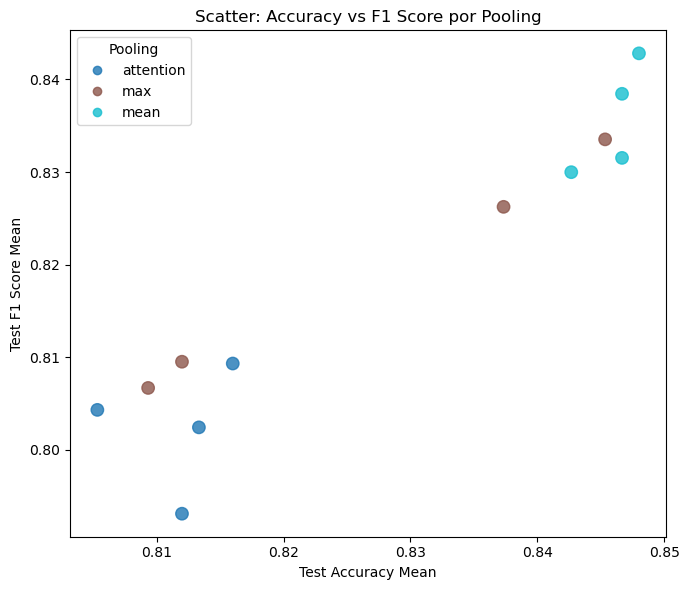

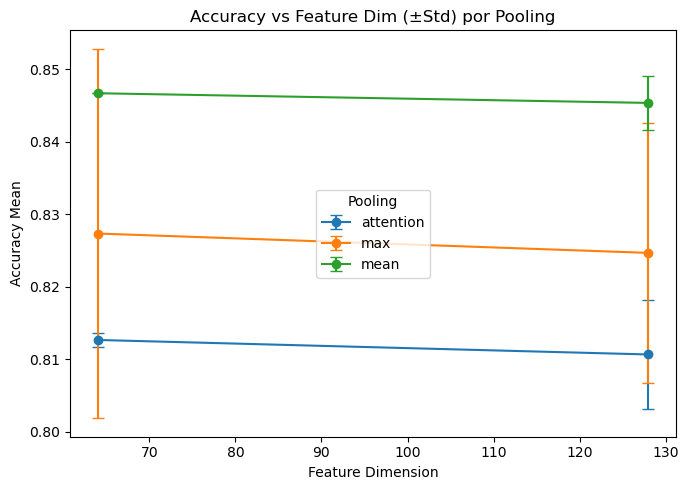

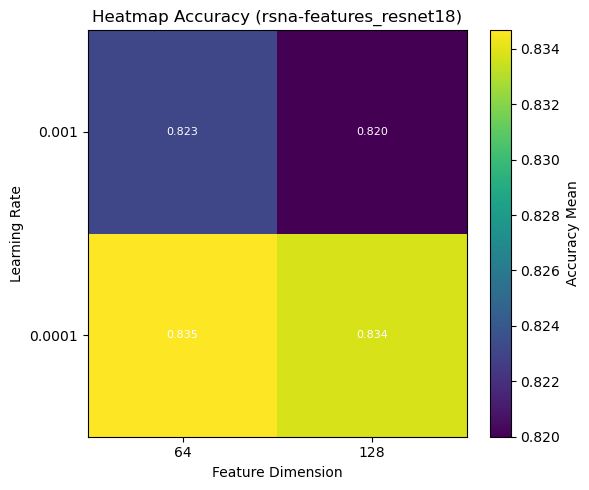

/tmp/ipykernel_2474460/1597386972.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=df['pooling'].unique())


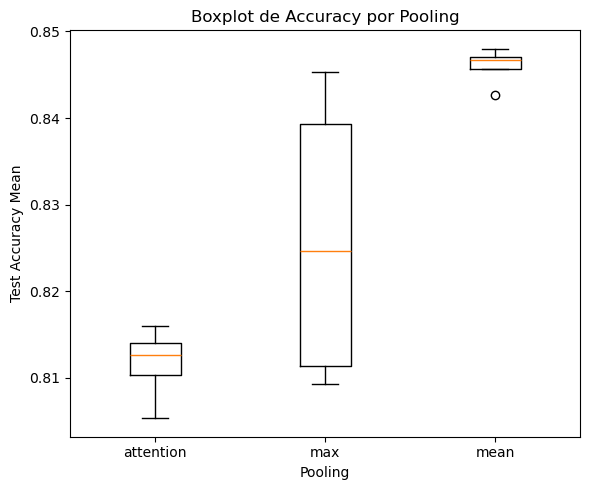

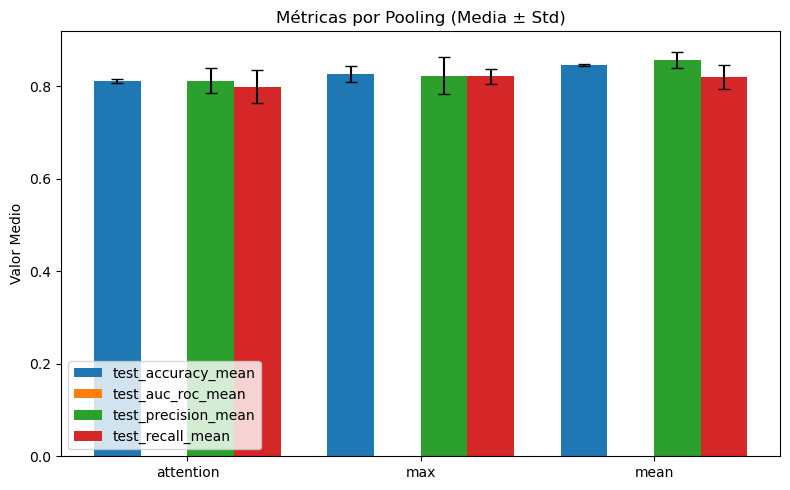

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ——————————————————————————————————————
# 0) Carga de datos
df = pd.read_csv("summary_by_config.csv")

# ——————————————————————————————————————
# 1) Scatter: Precisión vs F1 Score, coloreado por pooling
plt.figure(figsize=(7,6))
# codifica pooling_type como categorías para el colormap
pool_codes = df['pooling'].astype('category').cat.codes
scatter = plt.scatter(
    df['test_accuracy_mean'], 
    df['test_f1_score_mean'], 
    c=pool_codes, 
    s=80, 
    cmap='tab10',
    alpha=0.8
)
plt.xlabel("Test Accuracy Mean")
plt.ylabel("Test F1 Score Mean")
plt.title("Scatter: Accuracy vs F1 Score por Pooling")

# leyenda automática
handles, labels = scatter.legend_elements(prop="colors")
pool_labels = df['pooling'].astype('category').cat.categories
plt.legend(handles, pool_labels, title="Pooling", loc='best')
plt.tight_layout()
plt.show()

# ——————————————————————————————————————
# 2) Line + errorbar: Accuracy vs feature_dim para cada pooling (media ± std)
#    primero agrupamos
group = df.groupby(['pooling','feature_dim'])['test_accuracy_mean']
mean = group.mean().unstack('pooling')
std  = group.std().unstack('pooling')
dims = mean.index

plt.figure(figsize=(7,5))
for pooling in mean.columns:
    plt.errorbar(
        dims, 
        mean[pooling], 
        yerr=std[pooling], 
        marker='o', 
        capsize=4, 
        label=pooling
    )
plt.xlabel("Feature Dimension")
plt.ylabel("Accuracy Mean")
plt.title("Accuracy vs Feature Dim (±Std) por Pooling")
plt.legend(title="Pooling")
plt.tight_layout()
plt.show()

# ——————————————————————————————————————
# 3) Heatmap: Accuracy Mean para cada (learning_rate × feature_dim) en un dataset fijo
#    (ej. el primer dataset encontrado)
ds = df['dataset'].unique()[0]
sub = df[df['dataset']==ds]
lr_vals = sorted(sub['learning_rate'].unique())
fd_vals = sorted(sub['feature_dim'].unique())
mat = np.array([
    [ sub[(sub['learning_rate']==lr) & (sub['feature_dim']==fd)]['test_accuracy_mean'].mean()
      for fd in fd_vals ]
    for lr in lr_vals
])

plt.figure(figsize=(6,5))
hm = plt.imshow(mat, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(hm, label='Accuracy Mean')
plt.xticks(range(len(fd_vals)), fd_vals)
plt.yticks(range(len(lr_vals)), lr_vals)
plt.xlabel("Feature Dimension")
plt.ylabel("Learning Rate")
plt.title(f"Heatmap Accuracy ({ds})")

# Anotar valores
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        plt.text(j, i, f"{mat[i,j]:.3f}", ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()

# ——————————————————————————————————————
# 4) Boxplot: Distribución de Test Accuracy por tipo de pooling
plt.figure(figsize=(6,5))
groups = [ df[df['pooling']==p]['test_accuracy_mean'] for p in df['pooling'].unique() ]
plt.boxplot(groups, labels=df['pooling'].unique())
plt.xlabel("Pooling")
plt.ylabel("Test Accuracy Mean")
plt.title("Boxplot de Accuracy por Pooling")
plt.tight_layout()
plt.show()

# ——————————————————————————————————————
# 5) Bar chart: Comparativa de métricas media ± std por pooling
metrics = ['test_accuracy_mean','test_auc_roc_mean','test_precision_mean','test_recall_mean']
agg = df.groupby('pooling')[metrics].agg(['mean','std'])

x = np.arange(len(agg))
width = 0.2

plt.figure(figsize=(8,5))
for i, m in enumerate(metrics):
    means = agg[(m,'mean')]
    errs  = agg[(m,'std')]
    plt.bar(
        x + i*width, 
        means, 
        width=width, 
        yerr=errs, 
        capsize=4, 
        label=m
    )

plt.xticks(x + width*(len(metrics)-1)/2, agg.index)
plt.ylabel("Valor Medio")
plt.title("Métricas por Pooling (Media ± Std)")
plt.legend()
plt.tight_layout()
plt.show()


EJECUCIONES DE PANDA

In [ ]:
import itertools
import torch
import pandas as pd
from box import Box
from tqdm import tqdm
import csv

def run_all_experiments():
    # 1) Prepara el CSV y escribe el encabezado
    header = [
        "dataset", "pooling", "learning_rate", "feature_dim", "seed",
        "test_loss", "test_accuracy", "test_f1_score", "test_auc_roc",
        "test_precision", "test_recall"
    ]
    csv_file = "panda_results.csv"
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    all_runs = []

    # 2) Define tus combinaciones
    datasets = ["panda-patches_512_preset-features_UNI"]
    pooling_types = ["attention", "mean", "max"]
    learning_rates = [1e-3, 1e-4]
    feature_dims = [64, 128]
    seeds = [0, 1, 2, 3, 4]
    param_combinations = list(itertools.product(datasets, pooling_types, learning_rates, feature_dims))

    # 3) Bucle principal con tqdm
    for dataset, pooling, lr, feat_dim in tqdm(param_combinations, desc="Probando combinaciones"):
        for seed in seeds:
            # Ajustes según dataset
            input_feat_dim = 512 if "rsna" in dataset else 1024
            num_epochs = 50 if "rsna" in dataset else 15

            config = Box({
                "dataset_name": dataset,
                "input_feature_dim": input_feat_dim,
                "feature_dim": feat_dim,
                "pooling_type": pooling,
                "num_epochs": num_epochs,
                "learning_rate": lr,
                "batch_size": 1,
                "val_prop": 0.2,
                "seed": seed,
                "use_inst_distances": False,
                "adj_mat_mode": "relative"
            })

            # 4) Ejecuta experimento y recoge métricas
            result = run_experiment(config)

            # 5) Prepara la fila con parámetros + métricas
            row = {
                "dataset": dataset,
                "pooling": pooling,
                "learning_rate": lr,
                "feature_dim": feat_dim,
                "seed": seed
            }
            # Añade cada métrica del header (posiciones 5 en adelante)
            for metric in header[5:]:
                value = result.get(metric, None)
                row[metric] = value if isinstance(value, (int, float)) else ""

            all_runs.append(row)

            # 6) Añade la fila al CSV inmediatamente
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([row[col] for col in header])

    # 7) Muestra el DataFrame final en el notebook
    df = pd.DataFrame(all_runs)
    display(df)

# Ejecuta todo
run_all_experiments()


Probando combinaciones:   0%|          | 0/12 [00:00<?, ?it/s]wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:19<00:00, 111.20it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:19<00:00, 90.29it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2192, Acc: 0.9182, AUC: 0.9673, F1: 0.9437
Val   - Loss: 0.1249, Acc: 0.9484, AUC: 0.9878, F1: 0.9644
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.1829, Acc: 0.9324, AUC: 0.9770, F1: 0.9535
Val   - Loss: 0.1740, Acc: 0.9359, AUC: 0.9859, F1: 0.9566
Epoch 3/15
Train - Loss: 0.1830, Acc: 0.9319, AUC: 0.9778, F1: 0.9532
Val   - Loss: 0.1210, Acc: 0.9575, AUC: 0.9895, F1: 0.9704
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 4/15
Train - Loss: 0.1780, Acc: 0.9382, AUC: 0.9801, F1: 0.9575
Val   - Loss: 0.1209, Acc: 0.9439, AUC: 0.9908, F1: 0.9622
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 5/15
Train - Loss: 0.1784, Acc: 0.9409, AUC: 0.9807, F1: 0.9593
Val   - Loss: 0.1479, Acc: 0.9501, AUC: 0.9868, F1: 0.9657
Epoch 6/15
Train - Loss: 0.1701, Acc: 0.9420, AUC: 0.9832, F1: 0.9601
Val   - Loss

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9998
Accuracy: 0.9443, AUC: 0.9850
Precision: 0.9910, Recall: 0.9314, F1-Score: 0.9603
Confusion Matrix:
[[ 486   11]
 [  89 1208]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▆▇▇▇▇▆█▇█
train_auc,▁▅▅▆▇█▇█████
train_f1,▁▄▄▆▇▇▇▇▆█▇█
train_loss,█▃▃▃▃▂▂▁▃▂▃▂
val_accuracy,▆▅█▆▇▇███▇▇▁


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:48<00:00, 81.20it/s] 


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:17<00:00, 101.25it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2125, Acc: 0.9243, AUC: 0.9685, F1: 0.9480
Val   - Loss: 0.1750, Acc: 0.9422, AUC: 0.9802, F1: 0.9599
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.1751, Acc: 0.9344, AUC: 0.9790, F1: 0.9548
Val   - Loss: 0.1837, Acc: 0.9291, AUC: 0.9729, F1: 0.9507
Epoch 3/15
Train - Loss: 0.1631, Acc: 0.9420, AUC: 0.9821, F1: 0.9601
Val   - Loss: 0.1429, Acc: 0.9467, AUC: 0.9853, F1: 0.9628
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 4/15
Train - Loss: 0.1548, Acc: 0.9464, AUC: 0.9843, F1: 0.9631
Val   - Loss: 0.1821, Acc: 0.9422, AUC: 0.9842, F1: 0.9594
Epoch 5/15
Train - Loss: 0.1682, Acc: 0.9451, AUC: 0.9832, F1: 0.9623
Val   - Loss: 0.2181, Acc: 0.9382, AUC: 0.9793, F1: 0.9572
Epoch 6/15
Train - Loss: 0.1738, Acc: 0.9406, AUC: 0.9836, F1: 0.9591
Val   - Loss: 0.2841, Acc: 0.9121, AUC: 0.9764, F1: 0.9364
Epoch 7/15
Train - 

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8859
Accuracy: 0.9476, AUC: 0.9830
Precision: 0.9863, Recall: 0.9406, F1-Score: 0.9629
Confusion Matrix:
[[ 480   17]
 [  77 1220]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆█▇▆██
train_auc,▁▆▇█████
train_f1,▁▄▆█▇▆██
train_loss,█▃▂▁▃▃▃▄
val_accuracy,▇▄█▇▆▁▇▆


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:45<00:00, 83.39it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:19<00:00, 93.34it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2119, Acc: 0.9179, AUC: 0.9685, F1: 0.9437
Val   - Loss: 0.1572, Acc: 0.9427, AUC: 0.9840, F1: 0.9613
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.1853, Acc: 0.9324, AUC: 0.9771, F1: 0.9535
Val   - Loss: 0.1352, Acc: 0.9473, AUC: 0.9853, F1: 0.9635
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 3/15
Train - Loss: 0.1683, Acc: 0.9406, AUC: 0.9818, F1: 0.9592
Val   - Loss: 0.1987, Acc: 0.9467, AUC: 0.9825, F1: 0.9627
Epoch 4/15
Train - Loss: 0.1828, Acc: 0.9346, AUC: 0.9801, F1: 0.9551
Val   - Loss: 0.1495, Acc: 0.9546, AUC: 0.9852, F1: 0.9690
Epoch 5/15
Train - Loss: 0.1832, Acc: 0.9402, AUC: 0.9810, F1: 0.9589
Val   - Loss: 0.1771, Acc: 0.9478, AUC: 0.9837, F1: 0.9641
Epoch 6/15
Train - Loss: 0.1765, Acc: 0.9409, AUC: 0.9826, F1: 0.9593
Val   - Loss: 0.1724, Acc: 0.9427, AUC: 0.9818, F1: 0.9608
Epoch 7/15
Train - 

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9982
Accuracy: 0.9493, AUC: 0.9851
Precision: 0.9839, Recall: 0.9453, F1-Score: 0.9642
Confusion Matrix:
[[ 477   20]
 [  71 1226]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▃▅▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▅█▆███
train_auc,▁▅▇▇▇██
train_f1,▁▅█▆███
train_loss,█▄▁▃▃▂▃
val_accuracy,▅▆▆█▇▅▁


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:45<00:00, 83.89it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:19<00:00, 93.10it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2141, Acc: 0.9220, AUC: 0.9680, F1: 0.9464
Val   - Loss: 0.1707, Acc: 0.9410, AUC: 0.9840, F1: 0.9584
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.1856, Acc: 0.9324, AUC: 0.9779, F1: 0.9535
Val   - Loss: 0.2012, Acc: 0.9348, AUC: 0.9837, F1: 0.9563
Epoch 3/15
Train - Loss: 0.1773, Acc: 0.9352, AUC: 0.9794, F1: 0.9554
Val   - Loss: 0.1675, Acc: 0.9422, AUC: 0.9874, F1: 0.9611
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 4/15
Train - Loss: 0.1787, Acc: 0.9339, AUC: 0.9802, F1: 0.9546
Val   - Loss: 0.3659, Acc: 0.8679, AUC: 0.9820, F1: 0.9009
Epoch 5/15
Train - Loss: 0.1697, Acc: 0.9427, AUC: 0.9817, F1: 0.9605
Val   - Loss: 0.2647, Acc: 0.9422, AUC: 0.9860, F1: 0.9612
Epoch 6/15
Train - Loss: 0.1762, Acc: 0.9409, AUC: 0.9816, F1: 0.9594
Val   - Loss: 0.1474, Acc: 0.9450, AUC: 0.9893, F1: 0.9627
Final model saved t

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9871
Accuracy: 0.9560, AUC: 0.9892
Precision: 0.9872, Recall: 0.9514, F1-Score: 0.9690
Confusion Matrix:
[[ 481   16]
 [  63 1234]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▄▄▆▆▆▆▇▇▇▇▇█▇
train_auc,▁▅▆▆▇▆▇█▇██▇███
train_f1,▁▄▄▄▆▆▆▆▇▇▇▇▇█▇
train_loss,█▄▂▃▁▂▂▁▂▂▂▃▂▂▃
val_accuracy,▇▆▇▁▇▇▇▆▇▇▇███▆


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:49<00:00, 80.62it/s] 


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:17<00:00, 104.35it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2136, Acc: 0.9189, AUC: 0.9682, F1: 0.9444
Val   - Loss: 0.1778, Acc: 0.9371, AUC: 0.9833, F1: 0.9576
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.1811, Acc: 0.9339, AUC: 0.9790, F1: 0.9546
Val   - Loss: 0.1515, Acc: 0.9382, AUC: 0.9847, F1: 0.9581
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 3/15
Train - Loss: 0.1764, Acc: 0.9358, AUC: 0.9811, F1: 0.9558
Val   - Loss: 0.1702, Acc: 0.9501, AUC: 0.9846, F1: 0.9650
Epoch 4/15
Train - Loss: 0.1803, Acc: 0.9386, AUC: 0.9806, F1: 0.9578
Val   - Loss: 0.2093, Acc: 0.9450, AUC: 0.9837, F1: 0.9615
Epoch 5/15
Train - Loss: 0.1781, Acc: 0.9441, AUC: 0.9818, F1: 0.9616
Val   - Loss: 0.1730, Acc: 0.9478, AUC: 0.9851, F1: 0.9638
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 6/15
Train - Loss: 0.1825, Acc: 0.9389, AUC: 0.9820, F1: 0.9580
Val   - Loss

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9972
Accuracy: 0.9415, AUC: 0.9801
Precision: 0.9822, Recall: 0.9360, F1-Score: 0.9585
Confusion Matrix:
[[ 475   22]
 [  83 1214]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▇▅▇▆▇▆▆▇██▇
train_auc,▁▅▆▆▆▆▇▇▇▇▇▇██▇
train_f1,▁▄▅▅▆▅▇▆▇▆▆▇██▇
train_loss,█▃▂▃▂▃▂▂▃▂▃▂▂▁▃
val_accuracy,▅▆▇▇▇▇▃█▇█▅▆▇▇▁


Probando combinaciones:   8%|▊         | 1/12 [1:39:51<18:18:25, 5991.43s/it]

panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:56<00:00, 75.86it/s] 


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:15<00:00, 115.65it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2529, Acc: 0.9097, AUC: 0.9610, F1: 0.9382
Val   - Loss: 0.2011, Acc: 0.9365, AUC: 0.9769, F1: 0.9554
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.2382, Acc: 0.9226, AUC: 0.9720, F1: 0.9467
Val   - Loss: 0.2107, Acc: 0.9337, AUC: 0.9859, F1: 0.9552
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 3/15
Train - Loss: 0.2457, Acc: 0.9292, AUC: 0.9747, F1: 0.9515
Val   - Loss: 0.3025, Acc: 0.9359, AUC: 0.9839, F1: 0.9545
Epoch 4/15
Train - Loss: 0.2462, Acc: 0.9298, AUC: 0.9759, F1: 0.9519
Val   - Loss: 0.1659, Acc: 0.9439, AUC: 0.9874, F1: 0.9614
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 5/15
Train - Loss: 0.2533, Acc: 0.9294, AUC: 0.9762, F1: 0.9515
Val   - Loss: 0.1479, Acc: 0.9518, AUC: 0.9909, F1: 0.9669
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 6/15
Train

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8713
Accuracy: 0.9359, AUC: 0.9824
Precision: 0.9884, Recall: 0.9221, F1-Score: 0.9541
Confusion Matrix:
[[ 483   14]
 [ 101 1196]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆▆▆▇▇▇██
train_auc,▁▆▇▇▇█▇▇▇▇
train_f1,▁▄▆▆▆▇▇▇██
train_loss,▂▁▂▂▂▂▅▅▅█
val_accuracy,▅▄▅▆█▅▁▁█▆


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:43<00:00, 85.12it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:38<00:00, 46.71it/s] 


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2443, Acc: 0.9142, AUC: 0.9652, F1: 0.9412
Val   - Loss: 0.4270, Acc: 0.8413, AUC: 0.9762, F1: 0.9008
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 2/15
Train - Loss: 0.2219, Acc: 0.9317, AUC: 0.9760, F1: 0.9531
Val   - Loss: 0.2173, Acc: 0.9342, AUC: 0.9810, F1: 0.9545
Final model saved to ./models/panda/attention/model_attention.pth
Epoch 3/15
Train - Loss: 0.2407, Acc: 0.9328, AUC: 0.9771, F1: 0.9539
Val   - Loss: 0.3567, Acc: 0.9337, AUC: 0.9809, F1: 0.9525
Epoch 4/15
Train - Loss: 0.2542, Acc: 0.9312, AUC: 0.9747, F1: 0.9528
Val   - Loss: 0.4200, Acc: 0.9212, AUC: 0.9716, F1: 0.9467
Epoch 5/15
Train - Loss: 0.2650, Acc: 0.9310, AUC: 0.9777, F1: 0.9525
Val   - Loss: 0.4084, Acc: 0.9127, AUC: 0.9632, F1: 0.9407
Epoch 6/15
Train - Loss: 0.2629, Acc: 0.9356, AUC: 0.9784, F1: 0.9558
Val   - Loss: 0.4720, Acc: 0.8906, AUC: 0.9836, F1: 0.9296
Final model saved t